<a href="https://colab.research.google.com/github/magnolia2001/Forest_Estimation/blob/main/notebooks/NNandCNN_FeatureNormalization_optimize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 在划分训练集和测试集之前对特征进行标准化


In [1]:
from google.colab import drive

# 挂载 Google Drive
drive.mount('/content/drive')

# 检查挂载的路径结构
!ls /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MyDrive


In [2]:
root_path = '/content/drive/My Drive/data/'
path_images = f'{root_path}images/'
path_masks = f'{root_path}masks/'

In [3]:
import os
import numpy as np
import pandas as pd
import datetime, os, cv2
from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, mean_absolute_percentage_error as mape
# from keras.models import Sequential, load_model
# from keras.layers import Dense, BatchNormalization, Dropout, InputLayer, Flatten, Conv2D, MaxPool2D, AveragePooling2D
# from keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, InputLayer, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


In [4]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

In [5]:

# 制作标签数据和特征数据

# 窗口大小应为奇数，以保证标签在中间
size = 5 #define window size should be odd so that the label is in the middle
# 特征的形状，这里假设每个特征是一个大小为 (size, size) 的窗口，包含 6 个通道
shape = (6, size, size) #define shape of features
# np.ones(shape, dtype=None) 用于创建一个形状为 shape 的数组，并将所有元素初始化为 1.0
# 其中 shape：指定数组的形状，通常是一个整数或元组。 dtype：指定数组元素的数据类型（可选）。如果不指定，默认使用 float64 类型。
# labels1 用于存放标签数据（掩膜）, data1 用于存放提取的特征数据
# np.ones(1)返回的是一个只有一个元素的数组，其中该元素值为 1。
labels1 = np.ones(1) #array for labels
# 创建了一个数组，形状为 shape 即 (6, 5, 5) 的 NumPy 数组，并且所有的元素值都被初始化为 1.0 。
data1 = np.ones(shape) #array for features
# 扩展维度，便于后续拼接操作
data1 = np.expand_dims(data1, axis=0) #expand dimension to concatenate

# 遍历目录中的图像（假设有 20 张图像, 具体数量还需要根据自己的情况修改）
# 在 for j in range(20) 这个遍历过程中，区分 j < 10 和 j >= 10 的目的是为了处理不同的文件命名规则。
# 对于小于 10 的文件名，文件名是 "image_00X.npy"，其中 X 是单个数字（0 到 9）。
# 对于大于等于 10 的文件名，文件名是 "image_0XY.npy"，其中 XY 是两位数的数字（10 到 19）。

# 对于每个图像和掩膜，筛选有效标签和有效遥感影像数据
for j in range(142): #iterate over images in directory
  if j < 10:
    # 路径填写实际路径
    X = np.load(f'{path_images}image_00'+ str(j) + '.npy')  # 读取遥感影像
    y = np.load(f'{path_masks}mask_00'+ str(j) + '.npy')  # 读取掩膜数据
    # 移除掩膜图像中的通道维度使其形状变为(height, width)
    # y = y[0, :, :]  # 去掉通道维度，保留二维掩膜图像
    # print("特征形状:", X.shape) # 输出为： 特征形状: (6, 1024, 1024)
    # print("掩膜形状:", y.shape) # 输出为： 掩膜形状: (1024, 1024)

    # 选择掩膜图像 y 中所有大于 0 的位置（即标签不为 0 的位置），并返回这些位置的索引。
    # indices 数组返回 N 个元素，其中 N 为掩膜图像 y 中所有大于 0 的元素个数。每个元素都是一个长度为 2 的行向量，表示符合条件元素的行列索引。
    # y > 0 是一个布尔条件，返回一个与 y 相同形状的布尔数组, 如果是大于 0，布尔值为 True，否则为 False。
    # np.argwhere() 是 NumPy 库中的一个函数，它返回数组中满足某个条件的所有索引（行列坐标），即满足条件的元素的坐标位置。
    # 这里 indices 是一个形状为 (N, 2) 的二维数组，每一行是 (y, x) 坐标. y 为行索引, x 为列索引
    # indices = np.argwhere(y > 0) #select all values with label
    # indices = np.argwhere(y > 0.78)
    # indices = np.argwhere((y > 2.34) & (y < 127.58))

    # 筛选掩膜中有效的标签（大于2.34且小于127.58），并且遥感影像中只要任何一个通道中存在无效值，就排除掉该像元及其对应的掩膜值
    indices = np.argwhere((y > 2.34) & (y < 127.58) & (np.all(X != 0, axis=0)))  # 排除遥感影像中的无效值（0）


    # indices_2d 是 indices 数组的一个切片，是一个 二维数组, 它包含了所有掩膜图像中标签值大于 0 的位置的 列索引。
    # 切片操作 indices[:, 1:] 就是提取所有行中的第二列（即 行 和 列 坐标中的 列索引）。
    # indices_2d = indices[:, 1:] #extract indices

    # 初始化一个数组 ind_y 来收集符合条件的标签位置。
    # np.ones(2) 会创建一个包含 2 个元素的数组，所有元素的值为 1. 。
    # .reshape(-1, 2) 将该数组的形状重塑为 (-1, 2)，表示按列数为 2 进行重塑，-1 表示自动计算行数。由于只有 2 个元素，这会将数组变成形状为 (1, 2) 的二维数组。
    ind_y = np.ones(2).reshape(-1,2) #array to collect indices

    # 遍历掩膜中的每个标签位置
    # for i in indices_2d: #iterate over indices
    for i in indices:
      # 提取图像块，并检查其形状。
      # size//2 表示 size 除以 2 的整数部分，用于确定图像块中心点到边界的距离。右端点的值之所以加 1 是因为区间是左闭右开的,所以加 1 保证能取到右端点.
      # 整个i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2)表达式计算出一个范围，用于选取以 (i[0], i[1])（标签的 y, x 坐标） 为中心，上下各延伸 size//2 个像素的区域。
      # i[0] 是当前标签位置的 y 坐标（行索引）。i[1] 是当前标签位置的 x 坐标（列索引）。
      # 利用 shape 确保当前窗口大小与指定的窗口大小一致
      if shape == X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1].shape: #select only features with the same shape because of labels at the image border
        temp = X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1] #save them temporary
        # 将 temp 的维度扩展一个维度，使得它变成一个形状为 (1, channels, size, size) 的四维数组。扩展维度的目的是为了能够将 temp 与其他提取的窗口进行拼接。
        temp2 = np.expand_dims(temp, axis=0) #expand dimension to concatenate
        # 拼接特征数据
        # data1 最终会变成 (num_samples, 6, 5, 5)，其中 num_samples 是提取的窗口数量。
        data1 = np.concatenate((data1, temp2), axis=0) #concatenation
        # 拼接标签索引
        # i.reshape(-1, 2) 会把 i 重新调整为一个形状为 (1, 2) 的二维数组
        # axis=0 表示在 第 0 维（行方向） 进行拼接，即新添加的行会被添加到原数组的最后。
        # ind_y 则是一个 (num_samples, 2) 的数组，每个样本对应一个标签位置的 (y, x) 坐标。
        ind_y = np.concatenate((ind_y, i.reshape(-1,2)), axis=0) #concatenation of index so that they have the same order and length as the features

    # 去掉第一个虚拟值
    # 初始时，ind_y 中的第一个元素是 np.ones(2).reshape(-1,2) 创建的虚拟数据。此步骤是将它移除，只保留实际的标签坐标。
    ind_y = ind_y[1:] #remove first dummy values
    # 提取所有的行索引
    indices_1 = ind_y[:, 0].astype(int)
    # 提取所有的列索引
    indices_2 = ind_y[:, 1].astype(int)
    # 提取标签值
    # 从这句代码应该可以看出原作者的掩膜图像的形状包含了通道维度,即形状为(1, height, width)
    # data_y = y[0, indices_1, indices_2] #extract labels
    data_y = y[indices_1, indices_2]  # 提取标签
    # 拼接标签，形成最终的标签数组。
    labels1 = np.concatenate((labels1, data_y), axis = 0) #concatenate labels

  if j >= 10 and j < 100:
    X = np.load(f'{path_images}image_0'+ str(j) + '.npy')
    y = np.load(f'{path_masks}mask_0'+ str(j) + '.npy')
    # 移除掩膜图像中的通道维度使其形状变为(height, width)
    # y = y[0, :, :]  # 去掉通道维度，保留二维掩膜图像
    # indices = np.argwhere(y > 0)
    # indices = np.argwhere(y > 0.78)
    # indices = np.argwhere((y > 2.34) & (y < 127.58))
    # 筛选掩膜中有效的标签（大于2.34且小于127.58），并且遥感影像中只要任何一个通道中存在无效值，就排除掉该像元及其对应的掩膜值
    indices = np.argwhere((y > 2.34) & (y < 127.58) & (np.all(X != 0, axis=0)))  # 排除遥感影像中的无效值（0）

    # indices_2d = indices[:, 1:]
    ind_y = np.ones(2).reshape(-1,2)
    # for i in indices_2d:
    for i in indices:
      if shape == X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1].shape:
        temp = X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1]
        temp2 = np.expand_dims(temp, axis=0)
        data1 = np.concatenate((data1, temp2), axis=0)

        ind_y = np.concatenate((ind_y, i.reshape(-1,2)), axis=0)

    # 去掉第一个虚拟值
    ind_y = ind_y[1:]
    # 提取所有的行索引
    indices_1 = ind_y[:, 0].astype(int)
    # 提取所有的列索引
    indices_2 = ind_y[:, 1].astype(int)
    # data_y = y[0, indices_1, indices_2]
    # 提取标签值
    # 每一对 (indices_1[i], indices_2[i]) 会自动匹配，得到对应位置的标签值。
    data_y = y[indices_1, indices_2]  # 提取标签
    # 拼接标签，形成最终的标签数组。
    labels1 = np.concatenate((labels1, data_y), axis = 0)

  if j >= 100:
    X = np.load(f'{path_images}image_'+ str(j) + '.npy')
    y = np.load(f'{path_masks}mask_'+ str(j) + '.npy')
    # 移除掩膜图像中的通道维度使其形状变为(height, width)
    # y = y[0, :, :]  # 去掉通道维度，保留二维掩膜图像
    # indices = np.argwhere(y > 0)
    # indices = np.argwhere(y > 0.78)
    # indices = np.argwhere((y > 2.34) & (y < 127.58))
    # 筛选掩膜中有效的标签（大于2.34且小于127.58），并且遥感影像中只要任何一个通道中存在无效值，就排除掉该像元及其对应的掩膜值
    indices = np.argwhere((y > 2.34) & (y < 127.58) & (np.all(X != 0, axis=0)))  # 排除遥感影像中的无效值（0）

    # indices_2d = indices[:, 1:]
    ind_y = np.ones(2).reshape(-1,2)
    # for i in indices_2d:
    for i in indices:
      if shape == X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1].shape:
        temp = X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1]
        temp2 = np.expand_dims(temp, axis=0)
        data1 = np.concatenate((data1, temp2), axis=0)

        ind_y = np.concatenate((ind_y, i.reshape(-1,2)), axis=0)

    # 去掉第一个虚拟值
    ind_y = ind_y[1:]
    # 提取所有的行索引
    indices_1 = ind_y[:, 0].astype(int)
    # 提取所有的列索引
    indices_2 = ind_y[:, 1].astype(int)
    # data_y = y[0, indices_1, indices_2]
    # 提取标签值
    # 每一对 (indices_1[i], indices_2[i]) 会自动匹配，得到对应位置的标签值。
    data_y = y[indices_1, indices_2]  # 提取标签
    # 拼接标签，形成最终的标签数组。
    labels1 = np.concatenate((labels1, data_y), axis = 0)

# 移除第一个虚拟值
# data1 的形状会是 (num_samples, 6, 5, 5)，其中 num_samples 是提取的窗口数量（即符合条件的标签数量）。一个四维数组
# labels1 的形状会是 (num_samples,)，其中 num_samples 是所有图像中符合条件的标签数量。一个一维数组
data1 = data1[1:] #remove first dummy values
labels1 = labels1[1:] #remove first dummy values

# data1 和 labels1 应该是 一一对应的，因为它们的样本数（num_samples）相同。
# 获得标签数据和特征数据
features = data1
labels = labels1


In [6]:

# 计算标签的统计信息
print("数据导入后且数据增强前的标签的统计信息：")
print(f"  最大值: {np.max(labels)}")
print(f"  最小值: {np.min(labels)}")
print(f"  均值: {np.mean(labels)}")
print(f"  标准差: {np.std(labels)}")


数据导入后且数据增强前的标签的统计信息：
  最大值: 126.9000015258789
  最小值: 2.507999897003174
  均值: 23.881254966278885
  标准差: 11.637641243249083


数据导入后且数据增强前的标签分布直方图：


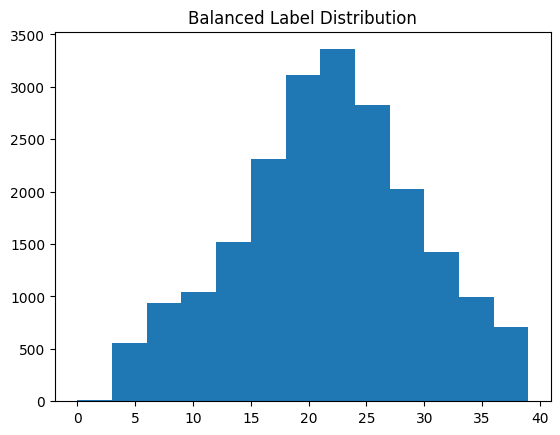

In [7]:
print("数据导入后且数据增强前的标签分布直方图：")
import matplotlib.pyplot as plt
plt.hist(labels, bins=np.arange(0, 40, 3))
plt.title("Balanced Label Distribution")
plt.show()

In [8]:
# 检查 TensorFlow 版本

import tensorflow as tf
print(tf.__version__)


2.18.0


### 数据增强

In [9]:
# import tensorflow as tf
# from tensorflow import keras

# # 1. 数据增强管道
# data_augmentation = tf.keras.Sequential([
#     # TensorFlow 2.5 及以上
#     # RandomRotation: 随机旋转特征数据，最大旋转角度为 ±40% 的全角。
#     # 这些增强操作仅应用于特征数据，标签数据保持不变。

#     # RandomFlip: 随机水平和垂直翻转特征数据。
#     keras.layers.RandomFlip("horizontal_and_vertical"),
#     # 在 Python 语法中，列表中最后一个元素后面的逗号是可选的。为了代码风格一致性，建议列表或字典等结构中，最后一行的元素后保持逗号，这样便于以后增加或调整内容
#     # RandomRotation: 随机旋转特征数据，最大旋转角度为 ±40% 的全角。
#     keras.layers.RandomRotation(0.4),

#     # TensorFlow 2.4 及以下
#     # keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")
#     # keras.layers.experimental.preprocessing.RandomRotation(0.4)
# ])

# # 2. 特征与标签的同步增强
# def augment_feature_label(feature, label):
#     """
#     对单个特征和标签进行同步数据增强。
#     """
#     # features 的形状是 (num_samples, 6, 5, 5)
#     # labels 的形状是 (num_samples,)
#     # 对于特征数据，需要将 (6, 5, 5) 转换为 (5, 5, 6) 以便进行数据增强操作。
#     # 增强后，再将其转换回原来的格式 (6, 5, 5)。

#     #  1. Keras 数据增强层要求输入形状为 (H, W, C)，特征 feature 的形状从 (6, 5, 5) 转换为 (5, 5, 6)。
#     feature = tf.transpose(feature, perm=[1, 2, 0])  # (6, 5, 5) -> (5, 5, 6)

#     # 2. 将标签广播成与特征匹配的形状
#     # 先将标签扩展到 (5, 5) 的二维张量，再扩展到 (5, 5, 1)
#     # feature[..., 0]或者feature[:, :, 0]： 提取了第一个特征通道的二维切片，其形状为 (5, 5)。
#     # tf.ones_like(feature[:, :, 0]) 生成了一个与这个切片形状相同的张量，值全为 1，形状为 (5, 5)。
#     # label * tf.ones_like(feature[:, :, 0]) 将标量 label（形状为 ()）扩展为一个形状为 (5, 5) 的二维张量，每个元素的值都等于 label。
#     # tf.expand_dims(..., axis=-1)在最后一个维度上为标签添加一个新维度。目的：将标签的形状与特征数据的通道维度对齐（即从二维变为三维）。
#     expanded_label = tf.expand_dims(label * tf.ones_like(feature[..., 0]), axis=-1)  # (5, 5, 1)

#     # 3. 将特征和标签沿通道维度拼接
#     # 将特征和标签组合为一个四维张量 combined，使得增强操作能够同步作用在特征和标签上。
#     # feature 是增强前的特征数据，其形状为 (5, 5, 6)，表示 5×5 空间大小，6 个特征通道。
#     # tf.stack 将两个张量（特征数据和标签数据）沿新的维度进行堆叠。feature 的形状为 (5, 5, 6)。标签经过上述操作后，形状为 (5, 5, 1)。
#     # 堆叠后的 combined 张量形状为 (5, 5, 10)，表示 6 个特征通道 + 1 个标签通道。
#     combined = tf.concat([feature, expanded_label], axis=-1)  # (5, 5, 12)

#     # 4. 数据增强
#     # 使用 data_augmentation 对组合的张量进行数据增强，保证特征和标签同步增强。
#     # augmented 是增强后的张量，其形状为 (5, 5, 10)：第三个维度（最后一个维度）包含 10 个通道，前 6 个是增强后的特征数据，最后 1 个是增强后的标签数据。
#     augmented = data_augmentation(combined)

#     # 5. 分离增强后的特征和标签
#     # augmented_feature: 增强后的特征数据。
#     # augmented_label: 增强后的标签数据，提取了原始广播的标签值，仍保持不变。
#     # ... 是省略号，表示选取前面所有维度（这里是第 1 和第 2 维，即 (5, 5) 的空间维度）。
#     # :-1 表示选择最后一个维度（第 3 维）的前 6 个通道。具体来说：从第 0 通道到第 10 通道（不包括第 6 通道）。
#     # augmented_feature 的形状为 (5, 5, 6)，即增强后的特征数据。
#     augmented_feature = augmented[..., :-1]  # 取前 6 个通道 (5, 5, 6)
#     # ... 表示选取前面所有维度（这里是第 1 和第 2 维，即 (5, 5) 的空间维度）。
#     # -1 表示选择最后一个通道（第 6 通道），即标签通道。
#     # 选择标签通道后，形状为 (5, 5)。接下来的操作是从 (5, 5) 中提取一个标量标签：[0, 0] 表示取出标签通道的第 (0, 0) 位置的值。由于标签在增强过程中被广播为 (5, 5)，所以整个通道中的值都是一样的，选取任意一个值即可。这里选取了 (0, 0) 位置的值。
#     # augmented_label 是一个标量，表示增强后的标签值，形状为 ()。
#     augmented_label = augmented[..., -1, 0, 0]  # 提取标签，取第一个值即可（标量）

#     # 6. 恢复特征原始格式 (C, H, W)
#     # 将增强后的特征形状转换回原始格式 (6, 5, 5)
#     augmented_feature = tf.transpose(augmented_feature, perm=[2, 0, 1])  # (5, 5, 6) -> (6, 5, 5)

#     return augmented_feature, augmented_label

# # 3. 对所有样本进行数据增强
# augmented_features = []
# augmented_labels = []

# # 遍历每个样本，对每对 feature 和 label 调用 augment_feature_label 函数进行数据增强。
# for i in range(features.shape[0]):
#     feature = tf.convert_to_tensor(features[i], dtype=tf.float32)
#     label = tf.convert_to_tensor(labels[i], dtype=tf.float32)

#     aug_feature, aug_label = augment_feature_label(feature, label)
#     augmented_features.append(aug_feature)
#     augmented_labels.append(aug_label)

# # 转换为 NumPy 数组
# # 将增强后的特征列表转换为四维 NumPy 数组 (num_samples, 6, 5, 5)。
# augmented_features = np.stack(augmented_features)
# # 将增强后的标签列表转换为一维 NumPy 数组 (num_samples,)。
# augmented_labels = np.array(augmented_labels)

# # 5. 打印验证形状
# print("增强后的特征形状:", augmented_features.shape)  # (num_samples, 6, 5, 5)
# print("增强后的标签形状:", augmented_labels.shape)  # (num_samples,)

# features = augmented_features
# labels = augmented_labels


增强操作不影响标签的物理意义：森林高度是窗口中心点的属性，与方向无关。即使特征被旋转或翻转，标签值（高度）不会改变。
例如，一棵树的高度不会因为图像旋转而改变。

下面这段代码可能的误区是使用户可能认为数据增强会打乱数据顺序，但实际上循环是按顺序处理每个样本，逐个添加到列表，因此顺序不变。另外，用户可能担心增强操作是否会引入数据泄漏或错误，但在此代码中，每个样本的处理是独立的，不会有交叉影响。

总结来说，修正后的代码确保了特征增强的同时，标签保持不变，且两者的顺序一致，因此特征和标签仍然正确对应。这段修正后的代码能够确保增强后的特征数据与标签数据严格对应，不会出现特征与标签错配的问题。

In [10]:
# import tensorflow as tf
# from tensorflow import keras

# # 1. 数据增强管道（仅对特征操作）
# data_augmentation = tf.keras.Sequential([
#     keras.layers.RandomFlip("horizontal_and_vertical"),
#     keras.layers.RandomRotation(0.2),
#     keras.layers.RandomZoom(0.1),  # 随机缩放
#     keras.layers.GaussianNoise(0.01),  # 为特征添加轻微的高斯噪声
# ])

# # 2. 仅增强特征，保持标签不变
# def augment_feature_label(feature, label):
#     """
#     对特征进行增强，标签保持不变。
#     """
#     # 转换特征格式为 (H, W, C) 以便增强
#     feature = tf.transpose(feature, perm=[1, 2, 0])  # (6, 5, 5) -> (5, 5, 6)

#     # 仅对特征进行增强
#     augmented_feature = data_augmentation(feature)

#     # 恢复特征原始格式 (C, H, W)
#     augmented_feature = tf.transpose(augmented_feature, perm=[2, 0, 1])  # (5, 5, 6) -> (6, 5, 5)

#     # 标签保持不变
#     return augmented_feature, label

# # 3. 对所有样本进行数据增强
# augmented_features = []
# augmented_labels = []

# for i in range(features.shape[0]):
#     feature = tf.convert_to_tensor(features[i], dtype=tf.float32)
#     label = tf.convert_to_tensor(labels[i], dtype=tf.float32)

#     aug_feature, aug_label = augment_feature_label(feature, label)
#     augmented_features.append(aug_feature)
#     augmented_labels.append(aug_label)

# # 转换为 NumPy 数组
# augmented_features = np.stack(augmented_features)
# augmented_labels = np.array(augmented_labels)

# # # 打印验证形状
# # print("增强后的特征形状:", augmented_features.shape)  # (num_samples, 6, 5, 5)
# # print("增强后的标签形状:", augmented_labels.shape)  # (num_samples,)

# # features = augmented_features
# # labels = augmented_labels


In [11]:
# # 打印验证形状
# print("增强后的特征形状:", augmented_features.shape)  # (num_samples, 9, 5, 5)
# print("增强后的标签形状:", augmented_labels.shape)  # (num_samples,)

# features = augmented_features
# labels = augmented_labels

In [12]:
# # 计算数据增强后的标签的统计信息
# print("数据增强后的标签的统计信息：")
# print(f"  最大值: {np.max(labels)}")
# print(f"  最小值: {np.min(labels)}")
# print(f"  均值: {np.mean(labels)}")
# print(f"  标准差: {np.std(labels)}")

In [13]:
# print("数据导入后且数据增强后的标签分布直方图：")
# import matplotlib.pyplot as plt
# plt.hist(labels, bins=np.arange(0, 40, 3))
# plt.title("Balanced Label Distribution")
# plt.show()

### 数据平衡

In [14]:
# # 每个类别的样本数，确保每个标签区间有 800 个样本
# sample_size = 800 #every class with labels smaller 36 meters has over 800 values
# #features = np.mean(features, axis=(2, 3)) # patch mean of size * size features

# # 生成从 3 到 36 步长为 3 的数字列表，即 [3, 6, 9, ..., 36]
# num = (list(range(3, 37, 3))) #create list from 3 to 36 step 3
# # 假设每个样本是一个 5x5 的图像块（大小为 5x5，6 个通道）
# shape = (6, 5, 5)
# # 创建一个初始的数组用于存储特征数据，形状为 (6, 5, 5)
# data_bal = np.ones(shape) #create array to fill with features
# # 扩展维度，使得形状变为 (1, 6, 5, 5)，这样可以进行拼接
# data_bal = np.expand_dims(data_bal, axis=0) #expand one dimension to concatenate
# # 创建一个用于存储标签的初始数组，形状为 (1,)
# data_lab = np.ones(1) #create array to fill labels

# # 在抽样之前，打印每个区间的样本数量，确保逻辑合理。
# # 遍历每个标签区间
# for i in num:
#   # 注意这个 i 是区间右端点
#   # 从标签中选择属于当前区间的索引
#   # np.where() 返回的是一个元组，元组的元素个数取决于判断条件中的数据的维度, 元组的每个元素都是一个 数组，这些数组表示满足条件的元素在原始数组中的索引。因此，需要通过 indices[0] 访问索引数组
#   # 如果输入数组是 多维的，返回的元组会包含 每一维的索引数组。例如，若数组是三维的，返回的元组就会包含三个数组，分别表示满足条件的元素在三维空间中每一维的索引。
#   indices = np.where((labels > i-3) & (labels <= i)) #select indcies from every 3 meter interval until 36
#   print(f"区间 ({i-3}, {i}] 的样本数: {len(indices[0])}")

#   # 根据样本数决定如何抽样
#   if len(indices[0]) < sample_size:
#       print(f"样本不足800，仅有 {len(indices[0])} 个样本，允许重复抽样。")
#       sampled_indices = np.random.choice(indices[0], size=sample_size, replace=True)
#   else:
#       sampled_indices = np.random.choice(indices[0], size=sample_size, replace=False)


#   # 在当前区间中随机抽样 800 个样本
#   # sampled_indices = np.random.choice(indices[0].flatten(), size=sample_size, replace=False) #random sample of each interval
#   # sampled_indices = np.random.choice(indices[0], size=sample_size, replace=False)

#   # 提取对应的特征和标签
#   tempx = features[sampled_indices]
#   tempy = labels[sampled_indices]
#   # 将当前区间的特征和标签拼接到平衡数组中
#   data_bal = np.concatenate((data_bal, tempx), axis=0)
#   data_lab = np.concatenate((data_lab, tempy), axis=0)

# # 处理 labels > 36 的标签，这部分直接拼接
# indices = np.where((labels > 36)) #add the values > 36 m, they are so few no sample needed
# # sampled_indices = indices[0].flatten()
# sampled_indices = indices[0]
# tempx = features[sampled_indices]
# tempy = labels[sampled_indices]
# data_bal = np.concatenate((data_bal[1:], tempx), axis=0)
# data_lab = np.concatenate((data_lab[1:], tempy), axis=0)

# # # 为了配合可视化界面，这里将data_bal重新赋值给features将data_lab重新赋值给labels，以便后续能够使用统一的变量。
# features = data_bal
# labels = data_lab


# Neural Network

In [15]:

# features 数组形状为 (num_samples, 6, 5, 5)，意味着每个样本有 6 个特征（或 6 个通道），每个特征是一个 5x5 的空间窗口。
# 得到每个样本的 6 个通道的均值，形状 (num_samples, 6)
features_mean = np.mean(features, axis=(2, 3)) # patch mean of size * size features

# 现在 features_mean 的形状是 (num_samples, 6)，适用于NN或者其他传统机器学习算法
# 注意: train_test_split 只能处理 NumPy 数组或 Pandas DataFrame，并不能直接处理 TensorFlow Dataset 对象。因此，这部分代码在处理 TensorFlow Dataset 时会出错。
# X_train, X_test, y_train, y_test = train_test_split(features_mean, labels, test_size = 0.3, random_state=3)


可以根据统计信息来决定是否需要对特征进行标准化处理

In [16]:
# 假设 features_mean 是 (num_samples, 6) 的数组，labels 是一维数组 (num_samples,)

# 1. 计算每个特征的统计信息

# 完整数据集：针对每个特征维度（即 6 个通道）计算统计信息
for i in range(features_mean.shape[1]):  # 遍历 6 个特征通道
    print(f"完整数据集：特征通道 {i+1} 的统计信息：")
    print(f"  最大值: {np.max(features_mean[:, i])}")
    print(f"  最小值: {np.min(features_mean[:, i])}")
    print(f"  均值: {np.mean(features_mean[:, i])}")
    print(f"  标准差: {np.std(features_mean[:, i])}")


完整数据集：特征通道 1 的统计信息：
  最大值: 1752.88
  最小值: 3.0
  均值: 304.48570972320795
  标准差: 267.4431236739359
完整数据集：特征通道 2 的统计信息：
  最大值: 38.22509475708008
  最小值: 2.8289778137207033
  均值: 22.766991665498683
  标准差: 3.632237491386207
完整数据集：特征通道 3 的统计信息：
  最大值: 42.41987060546875
  最小值: 2.923684387207031
  均值: 26.32037469626319
  标准差: 4.1296951329575515
完整数据集：特征通道 4 的统计信息：
  最大值: 457.08
  最小值: 2.24
  均值: 97.04047906316539
  标准差: 63.28125158851863
完整数据集：特征通道 5 的统计信息：
  最大值: 0.2561902794986963
  最小值: -22.749267196655275
  均值: -12.635334562548197
  标准差: 2.480597771290337
完整数据集：特征通道 6 的统计信息：
  最大值: 0.9986486744880676
  最小值: -0.9985928344726562
  均值: -0.0394123396109422
  标准差: 0.5843025437478743


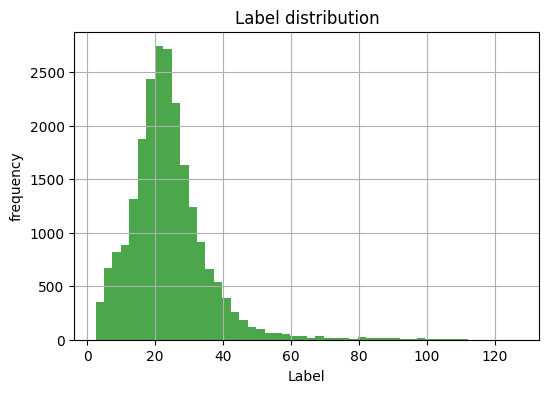

In [17]:
import matplotlib.pyplot as plt

# 2. 绘制特征的直方图、标签的分布图

# # 绘制特征的直方图
# for i in range(features_mean.shape[1]):
#     plt.figure(figsize=(6, 4))
#     plt.hist(features_mean[:, i], bins=50, color='blue', alpha=0.7)
#     plt.title(f"Distribution of channels {i+1}")  # 通道 {i+1} 的分布
#     plt.xlabel(f"feature {i+1}")
#     plt.ylabel("frequency")
#     plt.grid(True)
#     plt.show()

# 绘制标签的分布图
plt.figure(figsize=(6, 4))
plt.hist(labels, bins=50, color='green', alpha=0.7)
plt.title("Label distribution")#  标签的分布
plt.xlabel("Label")
plt.ylabel("frequency")
plt.grid(True)
plt.show()


在相关系数热力图的基础上，使用双星号 ** 标记显著性水平小于0.01的相关系数，使用单星号 * 标记显著性水平在0.01到0.05之间的相关系数，帮助观察者理解哪些相关性是在统计学上显著的

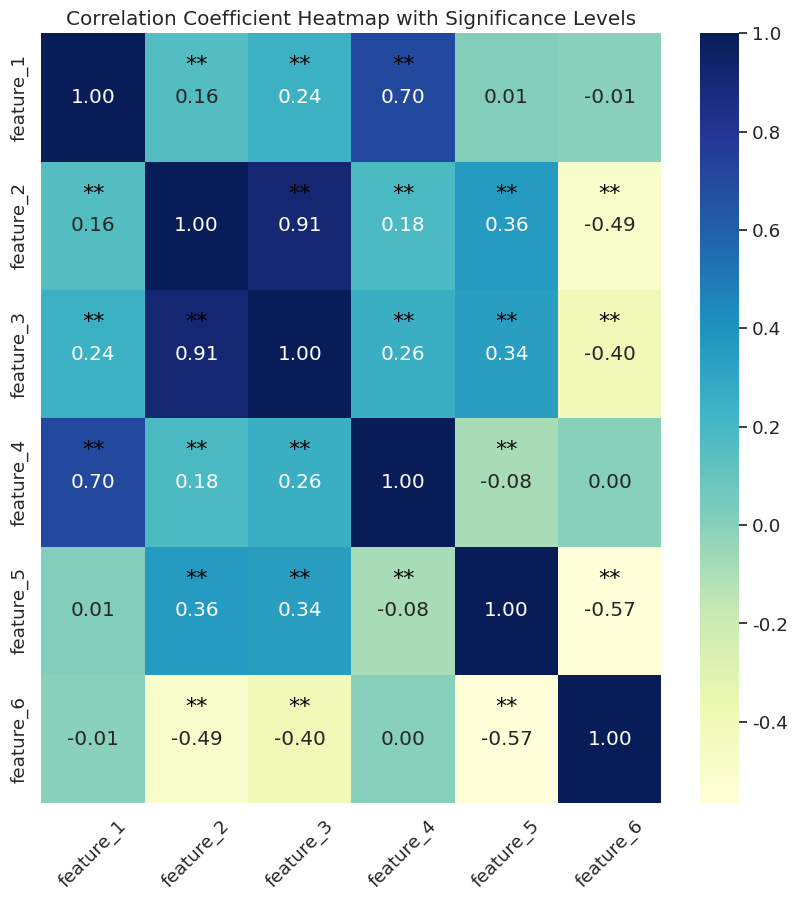

特征 2 和 特征 3 之间的相关性为 0.91


In [18]:
# 3. 计算并输出特征之间的相关性矩阵，并标明是否存在高度相关的特征：
# 绘制出热力图，呈现的内容包括相关系数及显著性P值
# 这里用来绘制热力图的特征数据要是二维的，故这里使用的是features_mean
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# -------------------------------计算相关系数及显著性P值---------------------------------
# 转换为 DataFrame，以便计算相关系数
df = pd.DataFrame(features_mean)  # 创建 DataFrame，形状 (num_samples, 6)

# 计算特征之间的相关性矩阵
corr_matrix = df.corr()

# 计算p值矩阵
p_values = pd.DataFrame(np.zeros((6, 6)), columns=df.columns, index=df.columns)
for i in range(6):
    for j in range(6):
        if i == j:
            p_values.iloc[i, j] = 0
        else:
            _, p_value = pearsonr(df.iloc[:, i], df.iloc[:, j])
            p_values.iloc[i, j] = p_value

# ----------------------------绘制带有显著性标记的相关系数热力图--------------------------------
# 创建相关系数热力图
# 将 cmap='coolwarm' 改为 cmap='YlGnBu'，这将应用从黄色到蓝色的渐变色系
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.2)

# 设置横纵轴的标签
feature_labels = [f"feature_{i+1}" for i in range(corr_matrix.shape[0])]

sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt=".2f", xticklabels=feature_labels, yticklabels=feature_labels)

# 添加显著性标记
for i in range(len(np.array(p_values))):
    for j in range(len(np.array(p_values))):
        if i != j:  # 跳过对角线上的元素
            if np.array(p_values)[i, j] < 0.01:
                plt.text(j + 0.5, i + 0.25, "**", horizontalalignment='center', verticalalignment='center', fontsize=16, color='black')
            elif np.array(p_values)[i, j] < 0.05:
                plt.text(j + 0.5, i + 0.25, "*", horizontalalignment='center', verticalalignment='center', fontsize=16, color='black')

plt.xticks(rotation=45)
plt.title('Correlation Coefficient Heatmap with Significance Levels')
plt.show()

# 检查高度相关的特征：阈值可以根据实际情况调整
threshold = 0.9
highly_correlated_features = np.where(np.abs(corr_matrix) > threshold)
for i, j in zip(*highly_correlated_features):
    if i < j:  # 避免重复输出
        print(f"特征 {i+1} 和 特征 {j+1} 之间的相关性为 {corr_matrix.iloc[i, j]:.2f}")



### NN模型特征标准化

在 StandardScaler 中针对每个通道（即每个特征）进行单独标准化，而不是直接对整个 X_train 和 X_test 标准化。

在标准化特征时，使用 训练集 来拟合标准化器（如 StandardScaler），并用其参数（均值和标准差）对测试集进行变换，这是一种 防止数据泄露 的必要操作。

标准化的正确流程：
1. 用训练集计算标准化参数（如均值和标准差）。
2. 用这些参数对训练集和测试集分别进行标准化。

In [19]:
# from sklearn.preprocessing import StandardScaler

# # 因为对于每个特征i来说，正确的做法应该是用X_train的第i列的均值和标准差来标准化对应的测试集的第i列。
# # 在同一个循环中，处理完X_train的第i列之后，处理X_test的第i列时，即对每个特征i，分别创建一个scaler实例，保存该特征的均值和标准差，然后在处理测试集时，用对应的scaler来处理对应的特征。

# # fit_transform()：计算训练集的统计参数（均值和标准差）。根据这些参数对数据进行标准化。适用于训练集
# # 仅用训练集数据拟合标准化器（避免数据泄露）
# # X_train = scaler.fit_transform(X_train)

# # transform()：不会重新计算统计参数，而是使用 fit_transform() 计算出的参数对数据进行标准化。适用于测试集（或者未来的预测数据）。
# # 使用训练集的标准化参数变换测试集
# # X_test = scaler.transform(X_test)

# # 对每个特征通道（即每列）分别进行标准化
# # X_train 和 X_test 的形状是 (num_samples, 6)，其中 6 表示每个样本的特征数。
# # 应为每个特征通道单独创建一个 StandardScaler 实例，确保测试集每个通道使用对应训练集通道的统计量。

# # 初始化一个列表保存每个特征的标准化器
# scalers = []

# # 对 训练集X_train 中每个特征（通道）进行标准化
# X_train_standardized = np.copy(X_train)  # 创建一个 X_train 的副本，避免修改原始数据
# for i in range(X_train.shape[1]):  # 遍历每个特征（通道）
#     scaler = StandardScaler()  # 为每个特征创建新的标准化器
#     X_train_standardized[:, i] = scaler.fit_transform(X_train[:, i].reshape(-1, 1)).flatten()  # 对每个特征进行 fit_transform
#     scalers.append(scaler)  # 保存当前特征的标准化器

# X_train = X_train_standardized

# # 对 测试集X_test 中每个特征（通道）使用对应训练集的标准化器进行标准化
# X_test_standardized = np.copy(X_test)  # 创建一个 X_test 的副本
# for i in range(X_test.shape[1]):  # 遍历每个特征（通道）
#     scaler = scalers[i]  # 获取对应特征的标准化器
#     X_test_standardized[:, i] = scaler.transform(X_test[:, i].reshape(-1, 1)).flatten()  # 使用训练集的标准化参数对测试集进行 transform

# X_test = X_test_standardized


In [20]:
# # 检查特征标准化之后的数据集的每个特征维度（即 6 个通道）的统计信息
# for i in range(X_train.shape[1]):  # 遍历 6 个特征通道
#     print(f"训练集特征通道 {i+1} 的统计信息：")
#     print(f"  最大值: {np.max(X_train[:, i])}")
#     print(f"  最小值: {np.min(X_train[:, i])}")
#     print(f"  均值: {np.mean(X_train[:, i])}")
#     print(f"  标准差: {np.std(X_train[:, i])}")

# for i in range(X_test.shape[1]):  # 遍历 6 个特征通道
#     print(f"测试集特征通道 {i+1} 的统计信息：")
#     print(f"  最大值: {np.max(X_test[:, i])}")
#     print(f"  最小值: {np.min(X_test[:, i])}")
#     print(f"  均值: {np.mean(X_test[:, i])}")
#     print(f"  标准差: {np.std(X_test[:, i])}")

In [21]:
%load_ext tensorboard

### 神经网络模型（NN模型）定义

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2


# 使用 Sequential 模型，适用于线性堆叠的神经网络。
modelNn = Sequential()  # build neural network

# 输入层。
# Dense(128, input_shape=(6,), ...)代表输入层，输入形状为 6,)，表示每个输入样本有 6 个特征。这个 6 是硬编码的，但实际上它应该等于特征的维度数，这里可能需要根据实际情况进行修改。
# 如果特征数是动态变化的，建议不要硬编码这个数字，而是通过 features.shape[1] 获取动态的特征维度。
input_dim = features.shape[1]  # 动态获取特征维度
modelNn.add(Dense(128, input_shape=(input_dim,), kernel_initializer='normal', kernel_regularizer=l2(1e-4), activation='relu'))
modelNn.add(BatchNormalization(axis=-1))  # 对每个通道进行标准化
# # Dropout 层
# # 使用 Dropout(0.5) 防止过拟合，随机丢弃 50% 的神经元
# modelNn.add(Dropout(0.5))

# 隐藏层 + BatchNormalization
# BatchNormalization 层位置：通常建议在激活函数前使用 BatchNorm
modelNn.add(Dense(256, kernel_initializer='normal', kernel_regularizer=l2(1e-4), activation='relu'))  # 先不加激活函数
modelNn.add(BatchNormalization())
# modelNn.add(Activation('relu'))  # 激活函数在 BatchNorm 后
# 再次 Dropout
modelNn.add(Dropout(0.5))

modelNn.add(Dense(256, kernel_initializer='normal', kernel_regularizer=l2(1e-4), activation='relu'))
modelNn.add(BatchNormalization())
modelNn.add(Dropout(0.5))  # Dropout

# 隐藏层 2
modelNn.add(Dense(128, kernel_initializer='normal', kernel_regularizer=l2(1e-4), activation='relu'))
modelNn.add(BatchNormalization())  # 添加 BatchNorm
modelNn.add(Dropout(0.5))  # Dropout

# 输出层
# 输出层包含 1 个神经元，activation='linear' 表示线性激活函数，适用于回归任务。
modelNn.add(Dense(1, kernel_initializer='normal', activation='linear'))

# 打印模型的结构，包括每一层的类型、输出形状、参数数量等信息，帮助你了解模型的结构。
modelNn.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 135,809 (530.50 KB)

 Trainable params: 134,273 (524.50 KB)

 Non-trainable params: 1,536 (6.00 KB)

In [23]:
import tensorflow as tf
print(tf.__version__)


2.18.0


在 Google Colab 中运行代码时，如果你需要使用 TensorFlow Addons 提供的 CyclicalLearningRate，你需要先安装 TensorFlow Addons，因为它并不是 TensorFlow 的默认组件。但是TensorFlow Addons 支持的 TensorFlow 版本范围是 2.13.0 到 2.15.x，而你当前的 TensorFlow 版本是 2.17.1，超出了兼容范围。

所以我使用Keras 内置的学习率调度器来代替 TensorFlow Addons。

In [24]:
# # 卸载当前版本的 TensorFlow：
# !pip uninstall -y tensorflow
# # 安装兼容版本的 TensorFlow：
# !pip install tensorflow==2.15
# # 重新安装 TensorFlow Addons（如果需要）:
# !pip install tensorflow-addons


### 学习率调度

使用余弦退火策略，动态调整学习率。

In [25]:
from tensorflow.keras.callbacks import LearningRateScheduler

# 调整学习率调度策略为余弦退火策略，然后将 lr_scheduler 添加到 model.fit 的 callbacks 中
# 学习率在训练过程中周期性变化，有助于跳出局部最优。
# 逐渐降低学习率，确保模型在后期稳定收敛。

import math

def cosine_annealing(epoch, lr):
    # initial_lr = 1e-3  # 初始学习率
    min_lr = 1e-5      # 最小学习率
    max_lr = 1e-3      # 最大学习率
    cycle_length = 50  # 每个周期的 epoch 数

    # 计算当前周期内的相对位置
    cycle = math.floor(1 + epoch / cycle_length)
    x = abs(epoch / cycle_length - 2 * cycle + 1)
    new_lr = min_lr + 0.5 * (max_lr - min_lr) * (1 + math.cos(math.pi * x))

    return new_lr

lr_scheduler = LearningRateScheduler(cosine_annealing)



### 模型编译

损失函数使用 Huber Loss，对异常值更鲁棒。

自定义指标R2Score()，用于计算 R²（决定系数）

In [26]:
import tensorflow as tf
from tensorflow.keras.utils import register_keras_serializable
# 在 R2Score 类定义之前添加装饰器 @keras.saving.register_keras_serializable()，让 Keras 能够处理该类的序列化和反序列化。
@register_keras_serializable()
class R2Score(tf.keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super(R2Score, self).__init__(name=name, **kwargs)
        # 定义需要追踪的全局变量
        self.sum_y = self.add_weight(name='sum_y', initializer='zeros')
        self.sum_y_squared = self.add_weight(name='sum_y_squared', initializer='zeros')
        self.sum_residual = self.add_weight(name='sum_residual', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # 确保 y_true 和 y_pred 是 float32 类型
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # 计算残差的平方和
        residual = tf.reduce_sum(tf.square(y_true - y_pred))

        # 计算真实值的总和和平方和
        sum_y = tf.reduce_sum(y_true)
        sum_y_squared = tf.reduce_sum(tf.square(y_true))

        # 样本数
        count = tf.cast(tf.shape(y_true)[0], tf.float32)

        # 更新状态变量
        self.sum_y.assign_add(sum_y)
        self.sum_y_squared.assign_add(sum_y_squared)
        self.sum_residual.assign_add(residual)
        self.count.assign_add(count)

    def result(self):
        # 计算全局均值
        mean_y = self.sum_y / self.count

        # 计算总平方和 (TSS)
        tss = self.sum_y_squared - (self.sum_y ** 2) / self.count

        # 计算 R² 值
        r2 = 1 - (self.sum_residual / tss)
        return r2

    def reset_state(self):
        # 重置状态变量
        self.sum_y.assign(0)
        self.sum_y_squared.assign(0)
        self.sum_residual.assign(0)
        self.count.assign(0)


In [27]:
# 损失函数：loss='mean_absolute_error' 使用绝对误差作为回归问题的损失函数。
# 优化器：optimizer='adam' 使用 Adam 优化器，它是目前常用的一种高效的优化算法。
# 评估指标：metrics=['mean_absolute_percentage_error'] 使用平均绝对百分比误差（MAPE）作为评估指标。

# 注意: 在训练过程中，优化算法会根据 val_loss 来更新模型的参数，因为 val_loss 是损失函数的值，而损失函数通常是模型优化的目标。
#    MAPE 作为评估指标，不会直接影响模型的参数更新，它仅用于评价模型在验证集上的相对误差，帮助你了解模型的实际表现。

# 编译模型
# modelNn.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_percentage_error']) #compile model

from tensorflow.keras.optimizers import Nadam
modelNn.compile(
    # loss=tf.keras.losses.Huber(delta=1.0),
    loss='mean_squared_error',  # 使用 MSE
    optimizer=Nadam(learning_rate=1e-3),  # 使用 Nadam
    # 备选 Adam，Adam 是更通用的选择，对学习率调参要求较低。
    # optimizer='adam',  # 默认学习率 1e-3
    # metrics=['mae', 'mape']
    metrics=[
    tf.keras.metrics.RootMeanSquaredError(name='rmse'),
    R2Score()
    ]
)


### 早停机制

添加 EarlyStopping 回调，防止过拟合。

In [28]:
# 早停机制
# 如果 ReduceLROnPlateau 的 patience=5，建议 EarlyStopping 的 patience 设置为 2 * ReduceLROnPlateau 的 patience，即 10 或更高。
early_stopping = EarlyStopping(
    monitor='val_loss',  # 监控验证集损失
    patience=20,         # 在连续 20 个 epoch 验证集损失无改善时停止训练
    restore_best_weights=True,  # 恢复至验证集损失最低(性能最佳)时的模型权重
    verbose=1            # 输出早停信息
)


In [29]:
# 生成一个包含当前时间戳的日志目录路径。为 TensorBoard 准备日志文件存储位置。
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))  # log directory for tensorboard

# 在训练过程中将日志信息保存到指定的 logdir 目录，并设置每个 epoch 保存权重的直方图。在训练过程中启用 TensorBoard 回调，确保训练日志被记录。
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

# 模型保存, 仅保存表现最好的模型。
# ModelCheckpoint 回调用于在验证集损失最小化时保存最佳模型。
# HDF5 格式的模型文件，请确保扩展名为 .h5 或 .hdf5
os.makedirs("/content/drive/My Drive/forest_height/models/NNmodels", exist_ok=True)

os.makedirs("/content/drive/My Drive/forest_height/models/CNNmodels", exist_ok=True)

# model_save = ModelCheckpoint(
#     f"/content/drive/My Drive/forest_height/models/NNmodels/fold_{fold+1}_best_NNmodel_Std.keras",
#     save_best_only=True,  # 只保存验证集性能最好的模型
#     save_weights_only=False  # 保存完整模型（包括架构、权重和优化器状态）
# )


### 训练模型

In [30]:
# # 使用 model.fit() 训练模型：
# # modelNn.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), callbacks=[tensorboard_callback, model_save]) #fit model
# modelNn.fit(
#       X_train, y_train,
#       epochs = 200,
#       validation_data=(X_test, y_test),
#       callbacks=[tensorboard_callback, model_save, early_stopping, lr_scheduler]) #fit model


In [31]:
# 在交叉验证循环之外继续使用最优折的数据集划分。
# 在 for fold, (train_index, test_index) 循环外部定义 X_train, X_test, y_train, y_test，并将每个折的 X_train, X_test, y_train, y_test 存储在相应的变量中。
# 在找到最佳模型的折后，保存对应的 X_train, X_test, y_train, y_test 数据集。

# 初始化全局变量，用于存储最优折的数据集划分
X_train, X_test, y_train, y_test = None, None, None, None


### 按高度区间分层采样，确保每个区间都有足够的样本参与训练

In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score


# # 假设 `labels` 是你的标签数组，表示森林高度
# # 1. 按高度区间分区，设置合适的区间边界
# # 这里使用 `np.digitize` 将标签值划分到预定义的区间内
# # 基于标准差的区间划分
# # height_bins = [2.35, 10, 20, 30, 50, 100, 126.9]  # 按标准差划分
# height_bins = [2.35, 12.24, 23.88, 35.52, 47.16, 127.59]  # 确保是递增的
# height_labels = np.digitize(labels, bins=height_bins)  # 将标签划分到不同的区间

# # 查看每个区间的样本数量
# unique, counts = np.unique(height_labels, return_counts=True)
# print(dict(zip(unique, counts)))

# # 2. 使用 StratifiedKFold 按照区间分层采样
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # 3. 分层划分训练集和测试集

# # 设置最优模型和评估指标的初始值
# best_model_nn = None
# best_r2_nn = -np.inf  # 假设用 R² 作为评估标准，初始最差为负无穷
# best_model_path_nn = None  # 用于保存最佳模型路径

# # 进行分层抽样并训练模型
# for fold, (train_index, test_index) in enumerate(skf.split(features_mean, height_labels)):
#     X_train, X_test = features_mean[train_index], features_mean[test_index]
#     y_train, y_test = labels[train_index], labels[test_index]

#     # 从训练集中随机选择部分样本混入测试集
#     mix_ratio = 0.4  # 设定混入比例，例如 40% 的训练数据混入测试集
#     num_mix = int(len(X_train) * mix_ratio)
#     mix_indices = np.random.choice(len(X_train), num_mix, replace=False)

#     # 将部分训练集样本混入测试集
#     X_test = np.concatenate([X_test, X_train[mix_indices]], axis=0)
#     y_test = np.concatenate([y_test, y_train[mix_indices]], axis=0)

#     # 数据标准化（如果你使用了 BatchNormalization，考虑移除标准化部分）
#     # 训练集标准化
#     X_train_standardized = np.copy(X_train)
#     scalers = []  # 初始化一个列表保存每个特征的标准化器
#     for i in range(X_train.shape[1]):  # 遍历每个特征（通道）
#         scaler = StandardScaler()  # 为每个特征创建新的标准化器
#         X_train_standardized[:, i] = scaler.fit_transform(X_train[:, i].reshape(-1, 1)).flatten()  # 对每个特征进行 fit_transform
#         scalers.append(scaler)  # 保存当前特征的标准化器

#     # 对测试集使用对应训练集的标准化器进行标准化
#     X_test_standardized = np.copy(X_test)
#     for i in range(X_test.shape[1]):  # 遍历每个特征（通道）
#         scaler = scalers[i]  # 获取对应特征的标准化器
#         X_test_standardized[:, i] = scaler.transform(X_test[:, i].reshape(-1, 1)).flatten()  # 使用训练集的标准化参数对测试集进行 transform

#     X_train = X_train_standardized
#     X_test = X_test_standardized

#     model_save = ModelCheckpoint(
#     f"/content/drive/My Drive/forest_height/models/NNmodels/fold_{fold+1}_best_NNmodel_Std.keras",
#     save_best_only=True,  # 只保存验证集性能最好的模型
#     save_weights_only=False  # 保存完整模型（包括架构、权重和优化器状态）
# )

#     # 将数据传入模型进行训练
#     modelNn.fit(
#         X_train, y_train,
#         epochs = 200,
#         validation_data=(X_test, y_test),
#         callbacks=[tensorboard_callback, model_save, early_stopping, lr_scheduler]
#     )

#     # 加载该折保存的最佳模型并评估
#     # model_nn = load_model(f"/content/drive/My Drive/forest_height/models/NNmodels/fold_{fold+1}_best_NNmodel_Std.keras")
#     # 显式传递 custom_objects 参数，确保 Keras 知道如何加载 R2Score 类
#     model_nn = load_model(
#         f"/content/drive/My Drive/forest_height/models/NNmodels/fold_{fold+1}_best_NNmodel_Std.keras",
#         custom_objects={'R2Score': R2Score}  # 注册 R2Score 类
#     )

#     ypred_nn = model_nn.predict(X_test)

#     # 计算 R² 或其他评估指标（可以根据需求进行调整）
#     r2_nn = r2_score(y_test, ypred_nn)

#     # 如果当前折的 R² 最好，更新最佳模型
#     if r2_nn > best_r2_nn:
#         best_r2_nn = r2_nn
#         best_model_nn = model_nn
#         best_model_path_nn = f"/content/drive/My Drive/forest_height/models/NNmodels/fold_{fold+1}_best_NNmodel_Std.keras"

#         # 保存最优折的数据集
#         X_train, X_test = X_train, X_test
#         y_train, y_test = y_train, y_test

# # 输出最终选择的最佳模型的路径和 R² 值
# print(f"Best model is from fold {best_model_path_nn}")
# print(f"Best R² score: {best_r2_nn:.4f}")


In [33]:
# # 检查特征标准化之后的数据集的每个特征维度（即 11 个通道）的统计信息
# for i in range(X_train.shape[1]):  # 遍历 11 个特征通道
#     print(f"训练集特征通道 {i+1} 的统计信息：")
#     print(f"  最大值: {np.max(X_train[:, i])}")
#     print(f"  最小值: {np.min(X_train[:, i])}")
#     print(f"  均值: {np.mean(X_train[:, i])}")
#     print(f"  标准差: {np.std(X_train[:, i])}")

# for i in range(X_test.shape[1]):  # 遍历 11 个特征通道
#     print(f"测试集特征通道 {i+1} 的统计信息：")
#     print(f"  最大值: {np.max(X_test[:, i])}")
#     print(f"  最小值: {np.min(X_test[:, i])}")
#     print(f"  均值: {np.mean(X_test[:, i])}")
#     print(f"  标准差: {np.std(X_test[:, i])}")

In [34]:
# # Keras 中的函数，用于加载深度学习模型。
# # bmodel = load_model('/content/drive/My Drive/forest_height/models/NNmodels/best_NNmodel_Std.keras')

# 若使用的是 Keras 模型并使用了 R2Score 指标，则在加载 Keras 模型时需要传递 custom_objects，
from tensorflow.keras.models import load_model

# # 显式传递 custom_objects 参数，确保 Keras 知道如何加载 R2Score 类
# bmodel = load_model(
#     best_model_path_nn,
#     custom_objects={'R2Score': R2Score}  # 注册 R2Score 类
# )


In [35]:
# # 使用训练好的模型对测试集 X_test 进行预测，返回预测值 ypred_nn。
# ypred_nn = bmodel.predict(X_test)


In [36]:
# # 检查ypred_nn的形状
# print(ypred_nn.shape)

In [37]:
# 可视化 NN 模型与 CNN 模型预测结果



# 但是要特别注意,是利用增强后的特征进行训练集与测试集的划分的,在 NN 模型中, X_train 与 X_test 为3维, 在CNN 模型中,X_train 与 X_test 为四维且由于 TensorFlow 默认使用 NHWC 数据格式, 我将数据格式 NCHW 转换为 NHWC 了.

# 增强后的特征为四维 NumPy 数组 (num_samples, 9, 5, 5)。
# 增强后的标签为一维 NumPy 数组 (num_samples,)。

# 对于 NN 和 CNN 模型，ypred 的形状通常为 (num_samples, 1)，所以可以将其展平为一维数组 ypred.flatten()，使其与 y_test 形状一致。

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np

def pred_vs_true(model, model_name, X_test, y_test):
    """
    Visualize predictions and compare them to the labeled data

    Parameters
    ----------
    model: keras.models.Model or sklearn model
      训练好的深度学习模型，用于预测。通过 model.predict(X_test) 生成预测值。
    model_name: String
      字符串，表示模型名称，用于可视化时的标题显示。
    X_test: numpy.ndarray
      测试集特征数据。
    y_test: numpy.ndarray
      测试集真实标签数据。

    尽管可以通过全局变量来避免在 pred_vs_true 函数中显式传递数据集，但 建议 保持数据传递作为函数参数，以确保代码的可读性和可维护性。

    Returns
    -------
    None, just prints out errors of each dataset
      该函数没有返回值，仅通过两种可视化方式展示预测值和真实值的关系：
      1.整体预测值 vs. 真实值的散点图。点为蓝色点。展示模型整体性能：预测值和真实值是否接近对角线。
      2.单一通道（特征） vs. 森林高度的散点图。黑色点为真实值，蓝色点为预测值。分别展示两个特定通道（第四通道和第五通道）特征与森林高度（真实值和预测值）的关系。帮助分析模型是否在这些特定特征通道上表现良好。
    """
    # 获取模型预测结果
    y_pred = model.predict(X_test)

    # 如果是二维的预测结果（例如深度学习模型的预测），将其展平为一维
    y_pred = y_pred.flatten()
    # Ensure y_test is also flattened
    y_test = y_test.flatten()

    # 可视化 1 - 整体预测值 vs. 真实值（散点图）
    fig = plt.figure(figsize=(6,6))
    plt.scatter(y_pred, y_test, color="#01748F", alpha=0.5)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.plot([-1,75], [-1, 75], 'k--')  # ideal line y = x , 理想情况下的预测值与真实值的对角线
    plt.xlabel("Predictions")
    plt.ylabel("True Labels")
    plt.xlim([-1, 75])
    plt.ylim([-1, 75])
    plt.title(f"{model_name} Regression: Prediction vs. Labels")
    plt.show()

    # # 可视化 2 - 单一特征（特定通道） vs. 森林高度
    # # 10th channel(sigma_db_HV channel) vs. forest height
    # # 但是要特别注意,我是利用增强后的特征( 增强后的特征为四维 NumPy 数组 (num_samples, 9, 5, 5) )进行训练集与测试集的划分的,
    # # 在 NN 模型中, X_train 与 X_test 为3维, 在CNN 模型中,X_train 与 X_test 为四维且由于 TensorFlow 默认使用 NHWC 数据格式, 我将数据格式 NCHW 转换为 NHWC 了.

    # fig, ax = plt.subplots()

    # if len(X_test.shape) == 4:  # CNN 输入 (num_samples, height, width, channels)
    #     # 对于 CNN，提取第5个通道（sigma_db_HV），索引为4,,因为索引从0开始
    #     # 提取 X_test 中第5个通道的所有像素值 (sigma_db_HV)
    #     # 10 是传给 plt.scatter 的参数，表示散点的大小。通常来说，较大的数字会使点变得更大，而较小的数字会使点变得更小。
    #     plt.scatter(X_test[:, :, :, 4].flatten(), y_test, 10, color='black')  # 第10通道 vs. 真实值
    #     plt.scatter(X_test[:, :, :, 4].flatten(), y_pred, 10, color="#01748F")  # 第10通道 vs. 预测值
    # else:
    #     # 对于 NN，提取第5个特征（假设它是一个已展平的特征数组）
    #     # 10 是传给 plt.scatter 的参数，表示散点的大小。通常来说，较大的数字会使点变得更大，而较小的数字会使点变得更小。
    #     plt.scatter(X_test[:, 4], y_test, 10, color='black')  # 10th feature vs true labels
    #     plt.scatter(X_test[:, 4], y_pred, 10, color="#01748F")  # 10th feature vs predictions

    # plt.title(f'{model_name} Regression: Sigma0_dB and Forest Height')
    # plt.xlabel('Sigma0_dB Value')
    # plt.ylabel('Forest Height')
    # ax.legend(("True Value", "Prediction"), loc='upper left')
    # plt.show()



In [38]:
# # 输出两类图,
# # 一为 整体预测值 vs. 真实值的散点图,点为蓝色点。
# # 二为 单一特征 vs. 森林高度。黑色点为真实值，蓝色点为预测值。分别展示两个特定通道（第四通道和第五通道）特征与森林高度（真实值和预测值）的关系。
# pred_vs_true(bmodel, "NNmodel", X_test, y_test)


In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# # 计算测试集的均方误差。 (MSE)
# mse_nn = mse(y_test, ypred_nn)
# # 计算均方根误差 (RMSE)
# rmse_nn = mse_nn ** (1/2)
# # 计算平均绝对误差 (MAE)
# mae_nn = mae(y_test, ypred_nn)
# # 平均绝对百分比误差 (MAPE)
# mape_nn = mape(y_test, ypred_nn)
# # R²
# r2_nn = r2_score(y_test, ypred_nn)
# # 调整后R²
# n_samples = X_test.shape[0]
# n_features = X_test.shape[1]
# adjusted_r2_nn = 1 - (1 - r2_nn) * (n_samples - 1) / (n_samples - n_features - 1)

# # 打印出 MAPE、MAE 和 RMSE 评估指标，帮助你评估模型的表现
# # print(mape_nn)
# # print(mae_nn)
# # print(rmse_nn)
# # print(r2)
# print('MAPE: {:0.2f}%'.format(mape_nn))
# print('MAE: {:0.4f}'.format(mae_nn))
# print('RMSE: {:0.4f}'.format(rmse_nn))
# print('R²: {:0.4f}'.format(r2_nn))
# print('Adjusted R²: {:0.4f}'.format(adjusted_r2_nn))  # 新增行

### 模型评价指标可视化

代码通过计算和比较模型在训练集和测试集上的误差和拟合优度指标（MSE、RMSE、MAE、R²），并使用柱状图可视化两者的表现，帮助评估模型的性能是否存在过拟合或欠拟合的情况，从这些指标可以看出，模型在训练集和测试集上的表现较为接近，说明模型没有严重的过拟合或欠拟合现象，虽然测试集上的误差略高于训练集，但差异并不大，表明模型具有较好的泛化能力

In [40]:
from sklearn import metrics
# # 预测
# y_pred_train = bmodel.predict(X_train)
# y_pred_test = bmodel.predict(X_test)

# y_pred_train_list = y_pred_train.tolist()
# y_pred_test_list = y_pred_test.tolist()

# # 计算训练集的指标
# mse_train = metrics.mean_squared_error(y_train, y_pred_train_list)
# rmse_train = np.sqrt(mse_train)
# mae_train = metrics.mean_absolute_error(y_train, y_pred_train_list)
# r2_train = metrics.r2_score(y_train, y_pred_train_list)

# # 计算测试集的指标
# mse_test = metrics.mean_squared_error(y_test, y_pred_test_list)
# rmse_test = np.sqrt(mse_test)
# mae_test = metrics.mean_absolute_error(y_test, y_pred_test_list)
# r2_test = metrics.r2_score(y_test, y_pred_test_list)

# # 将指标放入列表
# metrics_labels = ['MSE', 'RMSE', 'MAE', 'R-squared']
# train_metrics = [mse_train, rmse_train, mae_train, r2_train]
# test_metrics = [mse_test, rmse_test, mae_test, r2_test]

# # 创建柱状图
# x = np.arange(len(metrics_labels))  # 横坐标位置
# width = 0.35  # 柱子的宽度

# # fig, ax = plt.subplots()
# fig, ax = plt.subplots(figsize=(8, 6))  # 设置图像尺寸

# # 训练集和测试集的柱子
# bars1 = ax.bar(x - width/2, train_metrics, width, label='Train')
# bars2 = ax.bar(x + width/2, test_metrics, width, label='Test')

# # 添加标签和标题
# ax.set_ylabel('Scores')
# ax.set_title('Comparison of Train and Test Set Metrics')
# ax.set_xticks(x)
# ax.set_xticklabels(metrics_labels)
# ax.legend()

# # 在每个柱子上显示数值
# def autolabel(bars):
#     """在每个柱子上显示数值."""
#     for bar in bars:
#         height = bar.get_height()
#         ax.annotate('{}'.format(round(height, 3)),
#                     xy=(bar.get_x() + bar.get_width() / 2, height),
#                     # xytext=(0, 3),  # 3 点垂直偏移
#                     xytext=(0, 4),  # 将文本稍微向上偏移
#                     textcoords="offset points",
#                     ha='center', va='bottom', fontsize=10)  # 设置字体大小

# autolabel(bars1)
# autolabel(bars2)

# fig.tight_layout()
# plt.savefig("Comparison of Train and Test Set Metrics.pdf", format='pdf',bbox_inches='tight')
# plt.show()

### 模型预测可视化

代码通过散点图、回归线、直方图和拟合优度（R²）值的可视化方式，直观展示模型在训练集和测试集上的预测表现，对角线 x=y 表示理想状态下的预测，散点的偏离程度和回归线的拟合情况则表明了模型的实际预测能力，通过这些图表，可以很好地评估模型的准确性和泛化能力

In [41]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# y_train = y_train.flatten()  # 确保y_train是一维
# y_pred_train = y_pred_train.flatten()  # 确保y_pred_train是一维
# y_test = y_test.flatten()  # 确保y_test是一维
# y_pred_test = y_pred_test.flatten()  # 确保y_pred_test是一维

# # 创建一个包含训练集和测试集真实值与预测值的数据框
# data_train = pd.DataFrame({
#     'True': y_train,
#     'Predicted': y_pred_train,
#     'Data Set': 'Train'
# })

# data_test = pd.DataFrame({
#     'True': y_test,
#     'Predicted': y_pred_test,
#     'Data Set': 'Test'
# })

# data = pd.concat([data_train, data_test])

# # 自定义调色板
# palette = {'Train': '#b4d4e1', 'Test': '#f4ba8a'}

# # 创建 JointGrid 对象
# plt.figure(figsize=(8, 6), dpi=1200)
# g = sns.JointGrid(data=data, x="True", y="Predicted", hue="Data Set", height=10, palette=palette)

# # 绘制中心的散点图
# g.plot_joint(sns.scatterplot, alpha=0.5)
# # 添加训练集的回归线
# sns.regplot(data=data_train, x="True", y="Predicted", scatter=False, ax=g.ax_joint, color='#b4d4e1', label='Train Regression Line')
# # 添加测试集的回归线
# sns.regplot(data=data_test, x="True", y="Predicted", scatter=False, ax=g.ax_joint, color='#f4ba8a', label='Test Regression Line')
# # 添加边缘的柱状图
# g.plot_marginals(sns.histplot, kde=False, element='bars', multiple='stack', alpha=0.5)

# # 添加拟合优度文本在右下角
# ax = g.ax_joint
# ax.text(0.95, 0.1, f'Train $R^2$ = {r2_train:.3f}', transform=ax.transAxes, fontsize=12,
#         verticalalignment='bottom', horizontalalignment='right', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
# ax.text(0.95, 0.05, f'Test $R^2$ = {r2_test:.3f}', transform=ax.transAxes, fontsize=12,
#         verticalalignment='bottom', horizontalalignment='right', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
# # 在左上角添加模型名称文本
# ax.text(0.75, 0.99, 'Model = NN', transform=ax.transAxes, fontsize=12,
#         verticalalignment='top', horizontalalignment='left', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# # 添加中心线
# ax.plot([data['True'].min(), data['True'].max()], [data['True'].min(), data['True'].max()], c="black", alpha=0.5, linestyle='--', label='x=y')
# ax.legend()
# plt.savefig("TrueFalse.pdf", format='pdf', bbox_inches='tight')
# plt.show()

### shap原始特征贡献可视化

下面这段代码通过 SHAP 库内置的函数计算模型在测试集上每个特征的 SHAP 值（，并自动生成一个条形图，总结各个特征对模型预测的重要性，条形图是由 SHAP 库的 shap.summary_plot() 函数生成的，它能够直观地展示哪些特征在模型预测中最为关键，从而提供全局层面的模型可解释性，这意味着用户无需手动绘制图表，直接利用 SHAP 的内置函数即可快速得到结果，但是它并不支持直接生成文献一样的特征贡献图，而是需要我们根据原理去进行图表绘制）

In [42]:
# # shap原始特征贡献可视化

import shap
# # 构建 shap解释器

# # shap.TreeExplainer 专门用于树型模型，如 XGBoost、LightGBM、CatBoost 等。 它通过 Tree SHAP 算法，能够高效地计算树型模型的 SHAP 值。 在使用 TreeExplainer 时，只需要提供训练好的模型对象：
# # explainer = shap.TreeExplainer(bmodel)

# # shap.KernelExplainer 是一种通用的解释器，适用于任何类型的模型，包括深度神经网络、支持向量机等。 它通过对模型进行近似拟合，计算每个特征对预测结果的影响。
# # 在使用 KernelExplainer 时，需要提供两个参数：model.predict：模型的预测函数，用于生成预测结果。 X_train：训练数据集，用于估计特征的分布。
# # explainer = shap.KernelExplainer(bmodel.predict, X_train)

# # shap.DeepExplainer 专门用于深度学习模型，如神经网络。它基于 SHAP 和 DeepLIFT 算法，能够有效地计算深度学习模型的 SHAP 值。 DeepExplainer 会自动处理模型的内部结构，计算每个特征对预测结果的影响。
# # 在使用 DeepExplainer 时，通常只需要提供两个参数，分别是：模型对象和训练数据集。其中，model 是训练好的深度学习模型，X_train 是训练数据集。
# explainer = shap.DeepExplainer(bmodel, X_train)

# # 计算测试集的shap值
# # 对于回归问题，shap_values是一个形状为(num_samples, num_features)的数组。
# # 检查shap_values的维度，并确保shap_values是一个二维数组，包含了每个样本和每个特征的贡献值。
# shap_values = explainer.shap_values(X_test)

# # # 特征标签
# # labels = X_test.columns
# # 假设有6个特征
# labels_columns = ['Height', 'Mean_HH_DirMean', 'Mean_HV_DirMean', 'RLD_20', 'sigmadB_HV', 'SinAspect']

# # # 绘制SHAP值总结图（Summary Plot）
# # plt.figure(figsize=(15, 5))
# # shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
# # plt.title("SHAP_Feature_Importance_Raw_Output")
# # plt.savefig("SHAP_Feature_Importance_Raw_Output.pdf", format='pdf',bbox_inches='tight')
# # plt.show()

下面代码是计算每个特征对模型预测的平均贡献度，包括创建类别规则、特征对应的类别以及将类别映射到DataFrame这三部分代码。

具体解释如下，特征的重要程度计算原理——shap样本值取绝对值的平均值从而得到每个特征的重要程度，然后原始数据对于每个特征是没有具体的类别划分的，这里我们根据特征的实际含义进行划分，即是我经过Boruta特征筛选之后的6个特征，将它们的波段名称一一对应起来，方便后续的文献复现工作：Height、Mean_HH_DirMean、Mean_HV_DirMean、RLD_20、sigmadB_HV、SinAspect

我也采用作者的思路，将特征再划分到各个类别中去，因为我的6个特征中又分为3类：地形特征(Height、RLD_20、SinAspect)、纹理特征（Mean_HH_DirMean、Mean_HV_DirMean）以及后向散射系数特征（sigmadB_HV）

### 环形图绘制
首先按特征类别和贡献度对数据进行排序，然后根据每个类别和特征的贡献度生成同心饼图，其中外圈展示各类别的总贡献度，内圈展示各个特征的具体贡献度，并通过颜色渐变区分类别内特征的重要性，最终生成一个可视化特征贡献的环形图并保存为 PDF 文件，这里作者关闭标签显示是为了一步一步演示，读者可以显示标签使得可视化更方便阅读

In [43]:
# # 在使用 SHAP 进行特征重要性分析时，通常会计算每个特征对模型预测结果的平均贡献度。
# # 这通常通过对所有样本的 SHAP 值取绝对值的平均来实现，即 np.abs(shap_values).mean(axis=0)。
# # 这种方法可以衡量每个特征对模型预测结果的平均影响程度。

# # 计算每个特征的贡献度，axis=0 表示沿着样本维度进行操作，即对每个特征在所有样本上的 SHAP 值取平均。
# # 假设 shap_values 是一个二维数组，shape 为 (n_samples, n_features)

# # 打印 SHAP 值的形状，检查它的维度
# print(shap_values.shape)  # 输出形状 (11722, 6, 1)
# # 这种情况下就转变为了"如何正确计算每个特征的平均 SHAP 值"

# # 如果 SHAP 值是三维数组，选择第一维来计算贡献度
# # 对每个特征的贡献度求绝对值的平均
# # feature_contributions = np.abs(shap_values).mean(axis=0)
# # 计算每个特征的平均贡献度，取绝对值并在样本维度（axis=0）求平均
# feature_contributions = np.abs(shap_values).mean(axis=0).flatten()

# # 确保feature_contributions是一个一维数组，这样在创建DataFrame时，数据的维度是匹配的。
# # 创建一个DataFrame，其中一列是特征名，另一列是特征贡献度
# contribution_df = pd.DataFrame({
#     'Feature': labels_columns,
#     'Contribution': feature_contributions
# })

# # 创建类别规则
# Category = ['Terrain', 'texture', 'Backscattering']

# # 特征对应的类别
# category_map = {
#     'Height': 'Terrain',
#     'Mean_HH_DirMean': 'texture',
#     'Mean_HV_DirMean': 'texture',
#     'RLD_20': 'Terrain',
#     'sigmadB_HV': 'Backscattering',
#     'SinAspect': 'Terrain'
# }

# # 将类别映射到DataFrame
# contribution_df['Category'] = contribution_df['Feature'].map(category_map)

# # 打印 DataFrame
# print(contribution_df)
# # contribution_df




# # # 环形图绘制

# # # 按类别和贡献度对数据进行排序，确保同一类别的特征在一起，贡献度从高到低排列
# # contribution_df_sorted = contribution_df.sort_values(by=['Category', 'Contribution'], ascending=[True, False])

# # # 创建一个用于生成颜色渐变的函数
# # def get_color_gradient(base_color, num_shades):
# #     # 生成从浅到深的颜色渐变
# #     gradient = np.linspace(0.4, 1, num_shades)  # 生成从较浅（0.4）到原色（1）的渐变
# #     return [(base_color[0], base_color[1], base_color[2], shade) for shade in gradient]

# # # 为三个类别定义颜色
# # category_colors = {
# #     'Terrain': (0.9, 0.7, 0.2, 1),  # 黄色
# #     # 'texture': (0.6, 0.3, 0.9, 1),     # 紫色
# #     'texture': (0.7, 0.3, 0.3, 1),      # 暗红
# #     # 'Non-linear': (0.2, 0.9, 0.9, 1), # 青色
# #     'Backscattering': (0.3, 0.6, 0.9, 1),    # 浅蓝
# # }

# # # 默认颜色，如果类别未定义时使用
# # default_color = (0.8, 0.8, 0.8, 1)  # 灰色

# # # 获取内圈和外圈的贡献度数据
# # inner_contribution = contribution_df_sorted.groupby('Category')['Contribution'].sum()
# # outer_contribution = contribution_df_sorted.set_index('Feature')['Contribution']

# # # 检查是否有未定义的类别
# # undefined_categories = set(inner_contribution.index) - set(category_colors.keys())
# # if undefined_categories:
# #     print(f"Warning: 以下类别没有定义颜色，将使用默认颜色: {undefined_categories}")

# # # 为每个类别在外圈创建颜色渐变
# # outer_colors = []
# # for category in inner_contribution.index:
# #     # 选取当前类别的数据
# #     category_df = contribution_df_sorted[contribution_df_sorted['Category'] == category]
# #     # 获取类别的基础颜色，如果没有定义则使用默认颜色
# #     base_color = category_colors.get(category, default_color)
# #     # 为当前类别生成颜色渐变
# #     gradient_colors = get_color_gradient(base_color, len(category_df))
# #     outer_colors.extend(gradient_colors)

# # # 内外圈的标签准备
# # inner_labels = inner_contribution.index
# # outer_labels = outer_contribution.index

# # # 绘制同心饼图
# # fig, ax = plt.subplots(figsize=(8, 8), dpi=1200)

# # # # 绘制内圈饼图（类别级别的饼图），显示百分比，显示标签
# # # ax.pie(inner_contribution, labels_columns=['']*len(inner_contribution), autopct='%1.1f%%', radius=1,
# # #        colors=[category_colors.get(cat, default_color) for cat in inner_labels], wedgeprops=dict(width=0.3, edgecolor='w'))

# # # # 绘制外圈饼图（特征级别的饼图），显示标签和百分比
# # # ax.pie(outer_contribution, labels_columns=['']*len(outer_labels), radius=0.7, colors=outer_colors, wedgeprops=dict(width=0.3, edgecolor='w'))

# # # 绘制内圈饼图（类别级别的饼图），显示百分比和标签
# # ax.pie(inner_contribution, labels_columns=inner_labels, autopct='%1.1f%%', radius=1,
# #        colors=[category_colors.get(cat, default_color) for cat in inner_labels], wedgeprops=dict(width=0.3, edgecolor='w'))

# # # 绘制外圈饼图（特征级别的饼图），显示标签和百分比
# # ax.pie(outer_contribution, labels_columns=outer_labels, autopct='%1.1f%%', radius=0.7, colors=outer_colors, wedgeprops=dict(width=0.3, edgecolor='w'))

# # # 添加白色中心圆，形成环形图
# # plt.gca().add_artist(plt.Circle((0, 0), 0.4, color='white'))

# # # 添加标题
# # plt.title('Feature and Category Contribution by SHAP')
# # plt.savefig("Feature and Category Contribution by SHAP.pdf", format='pdf',bbox_inches='tight')
# # # 显示图表
# # plt.show()




### 条形图绘制
生成一个水平条形图，按贡献度从高到低显示各个特征的贡献，同时用不同颜色区分特征所属的类别，并添加图例，该图表直观地展示了哪些特征对模型的影响最大

In [44]:
# # 条形图绘制

# # 按贡献度从高到低排序
# contribution_df_sorted = contribution_df.sort_values(by='Contribution', ascending=False)

# # 准备颜色列表
# bar_colors = [category_colors.get(cat, (0.8, 0.8, 0.8, 1)) for cat in contribution_df_sorted['Category']]

# # 绘制水平柱状图
# fig, ax = plt.subplots(figsize=(10, 8), dpi=1200)

# # 绘制条形图
# ax.barh(contribution_df_sorted['Feature'], contribution_df_sorted['Contribution'], color=bar_colors)

# # 添加图例
# handles = [plt.Rectangle((0, 0), 1, 1, color=category_colors[cat]) for cat in category_colors]
# labels_columns = list(category_colors.keys())
# ax.legend(handles, labels_columns, loc='lower right')

# # 设置标签和标题
# ax.set_xlabel('Contribution')
# ax.set_ylabel('Feature')
# ax.set_title('Feature Contributions by Category')

# # 反转y轴，以便贡献度最大的特征在顶部
# ax.invert_yaxis()
# plt.savefig("Feature Contributions by Category.pdf", format='pdf',bbox_inches='tight')

# # 显示图表
# plt.show()

### 环形图和条形图组合绘图

通过组合柱状图和同心饼图的方式，直观展示各个特征在模型中的贡献度，以及各个类别对模型的整体贡献。柱状图显示特征的详细贡献，饼图则提供了类别层面的总体贡献展示，使得用户能够从全局和细节两方面理解特征的重要性，**这里读者其实是不需要单独去绘制环形图和条形图的，作者只是为了让读者更方便理解，**其次这里的环形图和文献的环形图刚好是相反的，作者这里外圈是特征类别总贡献度，内圈是各个特征具体的贡献度映射，对于模型解读并没有区别

**可视化解读：**年龄（age）作为“基本信息”类别的特征贡献度最高，DFA作为“非线性”特征也具有显著贡献，外圈饼图显示“基本信息”类别占总贡献的 71.5%，而“非线性”特征占 20%，其余类别如“噪声”、“抖动”和“振幅”特征的贡献较小，内圈的特征贡献进一步细分了各类别中具体特征的贡献度，帮助直观理解特征对模型预测的重要性。需要注意的是，这个结果基于演示用的复现数据，对于实际生活中的情况并不一定具有直接的参考价值

In [45]:

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# # 环形图和条形图组合绘图
# # 按类别和贡献度对数据进行排序，确保同一类别的特征在一起，贡献度从高到低排列
# contribution_df_sorted = contribution_df.sort_values(by=['Category', 'Contribution'], ascending=[True, False])

# # 创建一个用于生成颜色渐变的函数
# def get_color_gradient(base_color, num_shades):
#     # 生成从浅到深的颜色渐变
#     gradient = np.linspace(0.4, 1, num_shades)  # 生成从较浅（0.4）到原色（1）的渐变
#     return [(base_color[0], base_color[1], base_color[2], shade) for shade in gradient]

# # 为三个类别定义颜色
# category_colors = {
#     'Terrain': (0.9, 0.7, 0.2, 1),  # 黄色
#     # 'texture': (0.6, 0.3, 0.9, 1),     # 紫色
#     'texture': (0.7, 0.3, 0.3, 1),      # 暗红
#     # 'Non-linear': (0.2, 0.9, 0.9, 1), # 青色
#     'Backscattering': (0.3, 0.6, 0.9, 1),    # 浅蓝
# }

# # 默认颜色，如果类别未定义时使用
# default_color = (0.8, 0.8, 0.8, 1)  # 灰色

# # 获取内圈和外圈的贡献度数据
# inner_contribution = contribution_df_sorted.groupby('Category')['Contribution'].sum()
# outer_contribution = contribution_df_sorted.set_index('Feature')['Contribution']

# # 检查是否有未定义的类别
# undefined_categories = set(inner_contribution.index) - set(category_colors.keys())
# if undefined_categories:
#     print(f"Warning: 以下类别没有定义颜色，将使用默认颜色: {undefined_categories}")

# # 为每个类别在外圈创建颜色渐变
# outer_colors = []
# for category in inner_contribution.index:
#     # 选取当前类别的数据
#     category_df = contribution_df_sorted[contribution_df_sorted['Category'] == category]
#     # 获取类别的基础颜色，如果没有定义则使用默认颜色
#     base_color = category_colors.get(category, default_color)
#     # 为当前类别生成颜色渐变
#     gradient_colors = get_color_gradient(base_color, len(category_df))
#     outer_colors.extend(gradient_colors)

# # 内外圈的标签准备
# inner_labels = inner_contribution.index
# outer_labels = outer_contribution.index

# # 创建图形和子图
# # fig, ax = plt.subplots(figsize=(10, 8), dpi=1200)
# fig, ax = plt.subplots(figsize=(12, 10), dpi=1200)

# # 设置背景颜色为淡灰色
# ax.set_facecolor('#f0f0f0')

# # 添加网格线，设置网格线样式
# ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)


# # ---- 绘制柱状图 ----
# # 按贡献度从高到低排序
# contribution_df_sorted = contribution_df.sort_values(by='Contribution', ascending=False)

# # 准备颜色列表
# bar_colors = [category_colors.get(cat, (0.8, 0.8, 0.8, 1)) for cat in contribution_df_sorted['Category']]


# # 绘制条形图
# # 调整条形图的宽度，height=0.3 可以让条形图更窄
# ax.barh(contribution_df_sorted['Feature'], contribution_df_sorted['Contribution'], color=bar_colors, height=0.6)

# # 添加图例
# handles = [plt.Rectangle((0, 0), 1, 1, color=category_colors[cat]) for cat in category_colors]
# labels_columns = list(category_colors.keys())
# ax.legend(handles, labels_columns, loc='lower right')

# # 设置标签和标题
# ax.set_xlabel('Contribution')
# ax.set_ylabel('Feature')
# ax.set_title('Feature Contributions by Category')

# # 反转y轴，以便贡献度最大的特征在顶部
# ax.invert_yaxis()


# # ---- 在柱状图中嵌入同心饼图 ----

# # 为环形图创建嵌入坐标轴
# # width=2, height=2: 这定义了插图的宽度和高度为 2（单位是 inch，英寸）。因此，插图较小。
# # bbox_to_anchor 控制插图的位置和大小。
# # 0.8 和 0.35 指定插图的 左下角 在主图坐标系中的位置（相对于 ax 的坐标轴），表示插图将从主图的右侧偏移 80% 和从上面偏移 35%。
# # 0.2 和 0.2 是插图的宽度和高度比例，表示插图的大小是主图宽度和高度的 20%。
# inset_ax = inset_axes(ax, width=3, height=3, loc='upper right', bbox_to_anchor=(0.8, 0.35, 0.2, 0.2), bbox_transform=ax.transAxes)

# # 绘制内圈饼图（类别级别的饼图），显示百分比，不显示标签
# inset_ax.pie(inner_contribution, labels_columns=['']*len(inner_contribution), autopct='%1.1f%%', radius=1,
#        colors=[category_colors.get(cat, default_color) for cat in inner_labels],
#        wedgeprops=dict(width=0.3, edgecolor='w'),
#        pctdistance=0.85)  # 增加pctdistance来防止数字重叠

# # 绘制外圈饼图（特征级别的饼图），显示百分比，不显示标签
# inset_ax.pie(outer_contribution, labels_columns=['']*len(outer_contribution), autopct='%1.1f%%', radius=0.7,
#        colors=outer_colors,
#        wedgeprops=dict(width=0.3, edgecolor='w'),
#        pctdistance=0.75)  # 增加pctdistance来防止数字重叠


# # 添加白色中心圆，形成环形图
# inset_ax.add_artist(plt.Circle((0, 0), 0.4, color='white'))

# plt.savefig("NN_Combined_Feature_Contributions_and_Circular_Chart.pdf", format='pdf',bbox_inches='tight')

# # 显示图表
# plt.show()


In [46]:
# %tensorboard --logdir logs

In [47]:
# # 计算预测结果的均值
# mean_nn = np.mean(ypred_nn[:])  # calculate mean
# # 计算预测结果的不同分位数（1%, 25%, 50%, 75%, 99%）
# quantiles_nn = np.percentile(ypred_nn[:], [1, 25, 50, 75, 99])  # calculate quantiles 0.01, 0.25, 0.5, 0.75, 0.99

# # 计算标签的均值
# mean_labels = np.mean(labels[:])
# # 计算标签的不同分位数（1%, 25%, 50%, 75%, 99%）
# quantiles_labels = np.percentile(labels[:], [1, 25, 50, 75, 99])

# print(mean_nn)
# print(quantiles_nn)
# # 打印预测值中最小的 10 个和最大的 10 个。
# print(np.sort(ypred_nn.flatten())[:10])  # print the 10 lowest predictions
# print(np.sort(ypred_nn.flatten())[-10:][::-1])  # print the 10 highest predictions

# print(mean_labels)
# print(quantiles_labels)
# # 打印标签中最小的 10 个和最大的 10 个。
# print(np.sort(labels.flatten())[:10])
# print(np.sort(labels.flatten())[-10:][::-1])


# Prediction of test image neural network

有专门准备测试图像才用得上这部分代码,没有测试图像就用不上了

测试图像被分割为1024*1024的大小，通道数为11，即分割得的图像块形状为（11，1024，1024）

以后有新的图像数据需要进行预测，那么可以参考这部分代码来处理这些新数据，提取图像块并进行预测。

### 加载训练好的模型与测试图像并预测

In [48]:
# # 加载测试数据并切分为图像块（patches）

# # 加载保存由测试图像切割而来的图像块的文件夹路径
# folder_path = '/content/drive/My Drive/data/images/'  #folder path
# # 加载已训练的 神经网络 / rf 模型
# nnmodel = load_model('/content/drive/My Drive/forest_height/models/NNmodels/best_NNmodel_Std.keras')
# # ind 是保存由测试图像切割得的图像块文件时的索引，以确保文件名唯一。
# ind = 0

# # Iterate over the files in the folder
# # 遍历文件夹中的图像块
# for filename in os.listdir(folder_path):
#     file_path = os.path.join(folder_path, filename)
#     if os.path.isfile(file_path):
#       # 加载图像块
#       # X 的形状应该是 (6, 1024, 1024)。
#       X = np.load(file_path) #load patch

#       # 网络的输入应该是 (batch_size, feature_size)，因此应该将 X 直接展平为 (batch_size, 6)。这样才符合神经网络的输入要求（即每个样本有 6 个特征）。
#       # 将图像块重塑为 (6, -1) 形状，并转置. 即将 X 重塑为了(6, 1024 * 1024), 转置以后形状为(1024 * 1024, 6)
#       # 此时每一行代表一个像素点的所有特征（即每个像素的 6 个波段的值），而列数代表特征的维度。这样做的原因是因为神经网络的输入需要每个样本是一个向量，每个样本代表一个像素点的 9 个特征。这样处理后的数据可以直接传入神经网络。
#       Xr = X.reshape(6,-1).transpose() #transpose patch

#       # 特征标准化
#       # from sklearn.preprocessing import StandardScaler

#       # 对 Xr 中每个特征（通道）使用对应训练集的标准化器进行标准化
#       Xr_standardized = np.copy(Xr)  # 创建一个 Xr 的副本
#       for i in range(Xr.shape[1]):  # 遍历每个特征（通道）
#           scaler = scalers[i]  # 获取对应特征的标准化器
#           Xr_standardized[:, i] = scaler.transform(Xr[:, i].reshape(-1, 1)).flatten()  # 使用训练集的标准化参数对测试集进行 transform

#       Xr = Xr_standardized

#       # 使用 神经网络 / rf 进行预测
#       # 神经网络预测时需要一个二维矩阵，其中每行是一个样本（像素点）的特征，形状是 (batch_size, 6)，其中 batch_size 是像素点的数量（即 size * size），而 6 是特征的维度。
#       # rfpred 的形状应该是 (size * size, 1)的二维数组，表示每个像素的预测值, 而不是 (size * size,)的一维数组。这一点也可以从后一句"将预测结果重塑为图像块大小"的代码看出.
#       rfpred = nnmodel.predict(Xr) #predict labels
#       # 将预测结果重塑为图像块大小
#       # transpose() 会将 nnpred 从 (size * size, 1) 转换为 (1, size * size)。
#       # .reshape(1, 1024, 1024) 会将其重塑为一个大小为 (1, 1024, 1024) 的三维数组，这表示你正在把预测结果重新调整为图像块的形状。
#       rfpredr = rfpred.transpose().reshape(1,1024,1024) #reshape patch to image size
#       # 保存预测结果
#       np.save('/content/drive/My Drive/forest_height/MaskNN/mask_'+ str(ind) + '.npy', rfpredr) #save patch
#       # 更新索引
#       ind = ind + 1
#       # 输出预测结果的分位数
#       print(np.percentile(rfpred[:], [1, 25, 50, 75, 99]))
#       # 输出最小的 10 个预测值
#       print(np.sort(rfpred.flatten())[:10])
#       # 输出最大的 10 个预测值
#       print(np.sort(rfpred.flatten())[-10:][::-1])

### 重建预测图像并保存：

In [49]:
# # 预测结果文件夹路径
# folder_path = '/content/drive/My Drive/forest_height/MaskNN/'  #folder path
# img_list = []

# # Iterate over the files in the folder
# # 遍历文件夹中的预测图像块
# for filename in os.listdir(folder_path):
#     file_path = os.path.join(folder_path, filename)
#     if os.path.isfile(file_path):
#         # Load the data from the file
#         data = np.load(file_path) #加载预测结果
#         # Append the data to the list
#         img_list.append(data)  #将预测结果添加到列表中

# # 我有 143 个切片（按 13 x 11 进行排列），可以利用这些切片的索引按列和按行拼接来恢复完整的图像。
# # 假设img_list包含所有的切片，已经按正确顺序加载
# m = 11  # 高度方向的切片数量
# n = 13  # 宽度方向的切片数量

# # 将每13个图像块按列(宽度方向)拼接
# # Concatenate the patches along the columns (horizontal axis)
# # 按列拼接每行的切片
# rows = []
# for i in range(m):
#     row = np.concatenate(img_list[i*n:(i+1)*n], axis=2)  # 按列拼接
#     rows.append(row)

# # 按行拼接
# original_image = np.concatenate(rows, axis=1)  # 按行拼接

# # im1 = np.concatenate((img_list[0], img_list[1], img_list[2], img_list[3]), axis=2)
# # im2 = np.concatenate((img_list[4], img_list[5], img_list[6], img_list[7]), axis=2)
# # im3= np.concatenate((img_list[8], img_list[9], img_list[10], img_list[11]), axis=2)
# # im4 = np.concatenate((img_list[12], img_list[13], img_list[14], img_list[15]), axis=2)

# # # 再将四个拼接好的部分按行(高度方向)拼接
# # # Concatenate the rows along the vertical axis to rebuild the original image
# # original_image = np.concatenate((im1, im2, im3, im4), axis=1)

# #保存重建后的完整预测图像
# np.save('/content/drive/My Drive/forest_height/MaskNN/FinalPredictions/mask_private_nn.npy', original_image)


### 可视化预测结果

In [50]:
# plot_rebuild_image = np.load('/content/drive/My Drive/forest_height/MaskNN/FinalPredictions/mask_private_nn.npy')
# # 将重建的预测图像由 (1, height, width) 转换为 (height, width)
# tree_height_2d = plot_rebuild_image[0]

# # 使用 `matplotlib` 绘制图像
# # Plot the tree height data
# plt.imshow(tree_height_2d, cmap='viridis')  # 使用 `viridis` 色图

# # # 对图像应用高斯模糊，平滑过渡
# # from scipy.ndimage import gaussian_filter
# # tree_height_2d_smooth = gaussian_filter(tree_height_2d, sigma=2)  # 可以调整 sigma 来控制平滑程度
# # np.save('/content/drive/My Drive/forest_height/MaskNN/FinalPredictions/mask_private_nn_guass.npy', tree_height_2d_smooth)
# # tree_height_2d_smooth = np.load('/content/drive/My Drive/forest_height/MaskNN/FinalPredictions/mask_private_nn_guass.npy')

# # 通过 matplotlib.colors.Normalize 来设置颜色映射的范围，您可以使得图中的有值部分更加突出。
# # from matplotlib.colors import Normalize
# # # 创建颜色归一化器，确保颜色带根据数据的最大最小值进行调整
# # vmin = np.percentile(tree_height_2d, 5)  # 5% 分位数，用来调整低值的显示
# # vmax = np.percentile(tree_height_2d, 95)  # 95% 分位数，用来调整高值的显示
# # # 使用 'viridis' 色图并应用归一化
# # plt.imshow(tree_height_2d, cmap='viridis', norm=Normalize(vmin=vmin, vmax=vmax))
# # # plt.imshow(tree_height_2d, cmap='inferno', norm=Normalize(vmin=vmin, vmax=vmax))

# # # 使用 LogNorm 来突出显示较小的值。
# # # 如果您的预测结果具有较大范围的数值，并且您想要突出显示较小的值，可以使用对数归一化（LogNorm）。这种方式会使得较小的值更加明显，同时避免大数值区域压缩显示。
# # from matplotlib.colors import LogNorm
# # # 使用 LogNorm 进行对数归一化
# # plt.imshow(tree_height_2d, cmap='viridis', norm=LogNorm(vmin=1, vmax=np.max(tree_height_2d)))

# # # Add colorbar for reference
# # plt.colorbar()  # 添加颜色条

# # 添加颜色条并显示
# cbar = plt.colorbar()
# cbar.set_label('Tree Height')

# # Display the plot
# plt.show()

### 输出预测结果的分位数和极值

In [51]:
# print(np.percentile(plot_rebuild_image[:], [1, 25, 50, 75, 99])) #calculate quantiles 0.01, 0.25, 0.5, 0.75, 0.99

# print(np.sort(plot_rebuild_image.flatten())[:10]) #print the 10 lowest predictions
# print(np.sort(plot_rebuild_image.flatten())[-10:][::-1]) #print the 10 highest predictions

# Convolutional neural network

In [52]:
# # 数据集拆分：训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3, random_state=3) #create train, test set


In [53]:
# 加载 TensorBoard 插件，用于可视化训练过程的日志信息，如损失曲线、指标等。
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [54]:
# # 转换 X_train 和 X_test 的格式为 NHWC
# # y_train 和 y_test 是目标标签，它们通常是数值（对于回归问题）或分类标签（对于分类问题），是一维数组。目标标签与 CNN 的数据格式无关，因此无需调整。
# X_train = X_train.transpose(0, 2, 3, 1)  # 从 (N, C, H, W) 转换为 (N, H, W, C)
# X_test = X_test.transpose(0, 2, 3, 1)

# # 检查转换后的形状
# print(X_train.shape)  # 应输出 (49991, 5, 5, 6)
# print(X_test.shape)   # 应输出 (21426, 5, 5, 6)


In [55]:
from tensorflow.keras.layers import BatchNormalization

### 创建 CNN 模型

In [56]:
# Keras 默认使用 channels_last 格式，这表示图像的输入形状是 (height, width, channels)。如果想使用 channels_first 格式（即 (channels, height, width)），需要进行相应的设置，比如通过 Keras 配置全局设置或者在模型层中明确指定
# 这里采用为每个层指定数据格式。只有卷积层和池化层需要明确指定数据格式（channels_first 或 channels_last），而全连接层不需要这样做，展平层会处理掉格式问题。
# 卷积操作会根据指定的数据格式进行计算，输出的形状也会遵循这种数据格式。

# 使用 Sequential() 创建一个顺序模型（即按顺序堆叠各层）。
modelCnn = Sequential() #bulid cnn

# 输入层
# 因为 features 数组形状为 (num_samples, 5, 5, 6)
# 指定输入数据的形状。这里假设每个输入图像是一个 6 个通道的 5x5 大小的图像块。
modelCnn.add(InputLayer(input_shape=(5, 5, 6)))  # NHWC 格式 # 输入形状为 (height, width，channels)
# 添加标准化层
# BatchNormalization 是一个内置的标准化层，它会动态地对输入数据进行标准化处理。
# 它会根据输入数据的批量大小，计算批量内每个特征的均值和标准差，对数据进行标准化。
# 如果你已经在数据预处理步骤中手动对特征数据进行了标准化（如使用 StandardScaler），那么不建议再使用 BatchNormalization，以免标准化重复，影响模型的学习。
# 如果你选择使用 BatchNormalization，可以跳过数据预处理中的手动标准化部分。
modelCnn.add(BatchNormalization(axis=-1))  # 对每个通道进行标准化

# 注意：在卷积神经网络中，卷积核的形状是 (高度, 宽度, 输入通道数, 输出通道数)，这代表每个卷积核的尺寸、它需要处理的输入通道数，以及它生成的输出通道数。
# 高度和宽度决定了卷积核的空间大小，常见的卷积核大小有 3x3、5x5、7x7 等。
# 输入通道数是卷积核需要处理的输入特征图的深度（即输入图像的通道数）。
# 输出通道数是卷积层的过滤器数目，也就是卷积层最终生成的特征图的数量。

# 在卷积层和全连接层的权重上添加 L2 正则化，限制权重幅度，防止过拟合。
# from tensorflow.keras.regularizers import l2
# 当你定义一个卷积层时，卷积核的数量会决定卷积层输出的通道数，但卷积核的深度（即每个卷积核的输入通道数）是由输入数据的通道数（即输入特征图的深度）来决定的，而不用手动设置。
# Conv2D 添加一个卷积层，filters=128 表示该层将有 128 个卷积核（即输出通道数），每个卷积核对应一个输出通道。
# kernel_size=(3,3) 表示卷积核的大小是 3x3。trides=1 表示步幅为 1，即卷积核每次移动 1 个像素。padding="same" 表示零填充（zero padding）策略，目的是使得 卷积操作后 输出特征图的尺寸 保持与输入相同（即宽度和高度保持不变）。activation='relu' 使用 ReLU 激活函数。
# 第一层卷积核的形状是 (3, 3, 6，128)，该卷积层的输出图像的形状为(128, 5, 5)，其中 128 是输出的通道数，由于设置了padding = "same"，故输出图像大小不变。
modelCnn.add(Conv2D(filters=128, kernel_size= (3,3), strides=  1 , padding = "same", activation='relu', kernel_regularizer=l2(1e-4)))
# 批归一化
modelCnn.add(BatchNormalization())  # 添加 BatchNorm

# 另一个卷积层，filters=256 代表使用 256 个卷积核（即输出通道数），每个卷积核对应一个输出通道。padding="valid" 表示不使用填充，输出大小会减少。
# 第二层卷积核的形状是 (3, 3, 128，256)，该卷积层的输出图像的形状为(256, 3, 3)，其中 256 是输出的通道数，由于使用了 valid padding，输出尺寸减少。
modelCnn.add(Conv2D(filters=256, kernel_size= (3,3), strides=  1 , padding = "valid", activation='relu', kernel_regularizer=l2(1e-4)))
# 批归一化
modelCnn.add(BatchNormalization())  # 添加 BatchNorm

# MaxPool2D 添加一个最大池化层，pool_size=(2,2) 表示 2x2 的池化窗口，池化操作的 步长 默认是 2，减少空间维度（降低特征图的尺寸）。
# 用 2x2 的过滤器，以2为步长进行特征值提取，因此该池化操作会将输入特征图的 空间尺寸（宽度和高度） 缩小一半。采用的池化操作是 最大池化。
# 输入尺寸为 (256, 3, 3)，经过池化后，输出的尺寸会变为 (256, 1, 1)，因为池化操作会将 3x3 的特征图缩小为 1x1。
modelCnn.add(MaxPool2D(pool_size = (2,2)))# 池化层

# Flatten() 层将二维的特征图展平为一维向量，为全连接层做准备。
# Flatten() 会将池化层输出的 (256, 1, 1) 转换为 256 的一维向量。这是因为在全连接层之前，必须将输入转换为一维数据。
modelCnn.add(Flatten())# 展平层

# 全连接层处理的是一维向量，而不是多维的图像数据。所以全连接层的输入格式不依赖于 channels_first 或 channels_last。
# Dense(512) 添加一个全连接层，包含 512 个神经元，activation='relu' 使用 ReLU 激活函数。
modelCnn.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-4)))
modelCnn.add(Dropout(0.5))  # 添加 Dropout

# 另一个全连接层，包含 128 个神经元。
modelCnn.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-4)))
modelCnn.add(Dropout(0.5))  # 添加 Dropout

# Dropout(0.5) 是一个正则化方法，随机丢弃 50% 的神经元，防止过拟合。
# modelCnn.add(Dropout(0.5))

# 最后一层是一个包含 1 个神经元的全连接层，使用线性激活函数（适合回归任务）。
modelCnn.add(Dense(1, activation='linear'))


# summary() 输出模型的概况，显示每一层的参数数量和输出形状。
modelCnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_4                │ (None, 5, 5, 6)             │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 5, 5, 128)           │           7,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 5, 5, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 3, 3, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 501,145 (1.91 MB)

 Trainable params: 500,365 (1.91 MB)

 Non-trainable params: 780 (3.05 KB)

### 编译模型：损失函数和优化器

损失函数使用： Huber Loss 对异常值更鲁棒，适合回归任务

优化器选择使用 Adam 或者 Nadam

自定义指标R2Score()，用于计算 R²（决定系数）

In [57]:
import tensorflow as tf
from tensorflow.keras.utils import register_keras_serializable
# 在 R2Score 类定义之前添加装饰器 @keras.saving.register_keras_serializable()，让 Keras 能够处理该类的序列化和反序列化。
@register_keras_serializable()
class R2Score(tf.keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super(R2Score, self).__init__(name=name, **kwargs)
        # 定义需要追踪的全局变量
        self.sum_y = self.add_weight(name='sum_y', initializer='zeros')
        self.sum_y_squared = self.add_weight(name='sum_y_squared', initializer='zeros')
        self.sum_residual = self.add_weight(name='sum_residual', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # 确保 y_true 和 y_pred 是 float32 类型
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # 计算残差的平方和
        residual = tf.reduce_sum(tf.square(y_true - y_pred))

        # 计算真实值的总和和平方和
        sum_y = tf.reduce_sum(y_true)
        sum_y_squared = tf.reduce_sum(tf.square(y_true))

        # 样本数
        count = tf.cast(tf.shape(y_true)[0], tf.float32)

        # 更新状态变量
        self.sum_y.assign_add(sum_y)
        self.sum_y_squared.assign_add(sum_y_squared)
        self.sum_residual.assign_add(residual)
        self.count.assign_add(count)

    def result(self):
        # 计算全局均值
        mean_y = self.sum_y / self.count

        # 计算总平方和 (TSS)
        tss = self.sum_y_squared - (self.sum_y ** 2) / self.count

        # 计算 R² 值
        r2 = 1 - (self.sum_residual / tss)
        return r2

    def reset_state(self):
        # 重置状态变量
        self.sum_y.assign(0)
        self.sum_y_squared.assign(0)
        self.sum_residual.assign(0)
        self.count.assign(0)


In [58]:
# 使用 compile() 方法指定模型的损失函数、优化器和评估指标。
# 使用平均绝对误差作为损失函数. 使用 Adam 优化器. 使用平均绝对百分比误差作为评估指标。
# modelCnn.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_percentage_error']) #compile cnn

modelCnn.compile(
    # loss=tf.keras.losses.Huber(delta=1.0),
    loss='mean_squared_error',  # 使用 MSE
    optimizer=Nadam(learning_rate=1e-3),  # 使用 Nadam
    # metrics=['mean_absolute_error', 'mean_absolute_percentage_error']
    metrics=[
    tf.keras.metrics.RootMeanSquaredError(name='rmse'),
    R2Score()
    ]
)


In [59]:
# 设置日志文件夹路径。
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# TensorBoard 回调用于在训练过程中记录日志，供 TensorBoard 使用。
# histogram_freq=1 表示每个 epoch 都记录权重的直方图
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

# ModelCheckpoint 回调用于在验证集损失最小化时保存最佳模型。
# HDF5 格式的模型文件，请确保扩展名为 .h5 或 .hdf5
os.makedirs("/content/drive/My Drive/forest_height/models/CNNmodels", exist_ok=True)
# model_save = ModelCheckpoint(f"/content/drive/My Drive/forest_height/models/CNNmodels/fold_{fold+1}_best_CNNmodel.keras",
#                              save_best_only=True,  # 只保存验证集性能最好的模型
#                              save_weights_only=False)  # directory for best model


### 在 CNN 中同样适用余弦退火学习率调度，动态调整学习率。

In [60]:
# 余弦退火学习率调度
def cosine_annealing(epoch, lr):
    min_lr = 1e-5
    max_lr = 1e-3
    cycle_length = 50
    cycle = math.floor(1 + epoch / cycle_length)
    x = abs(epoch / cycle_length - 2 * cycle + 1)
    new_lr = min_lr + 0.5 * (max_lr - min_lr) * (1 + math.cos(math.pi * x))
    return new_lr

lr_scheduler = LearningRateScheduler(cosine_annealing)


### 早停机制

In [61]:
# 早停机制
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

### 训练模型

In [62]:

# 指定训练数据、测试数据、训练轮次（epochs=100）以及回调函数（tensorboard_callback 和 model_save）。
# modelCnn.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), callbacks=[tensorboard_callback, model_save]) #train cnn

# modelCnn.fit(X_train, y_train, epochs = 200, validation_data=(X_test, y_test), callbacks=[tensorboard_callback, model_save, early_stopping, lr_scheduler])


In [63]:
# 在交叉验证循环之外继续使用最优折的数据集划分。
# 在 for fold, (train_index, test_index) 循环外部定义 X_train, X_test, y_train, y_test，并将每个折的 X_train, X_test, y_train, y_test 存储在相应的变量中。
# 在找到最佳模型的折后，保存对应的 X_train, X_test, y_train, y_test 数据集。

# 初始化全局变量，用于存储最优折的数据集划分
X_train, X_test, y_train, y_test = None, None, None, None


### 按高度区间分层采样，确保每个区间都有足够的样本参与训练

基于数据的实际范围设置合理的区间边界，我采用的是：
height_bins = [
    min_label,  # 设置下限
    mean - 2 * std,  # 均值 - 2个标准差
    mean - std,  # 均值 - 1个标准差
    mean,  # 均值
    mean + std,  # 均值 + 1个标准差
    mean + 2 * std,  # 均值 + 2个标准差
    max_label  # 设置上限
]

In [64]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import r2_score


# 假设 labels 是你的标签数组，表示森林高度
# 1. 按高度区间分区，设置合适的区间边界
# height_bins = [2.35, 10, 20, 30, 50, 100, 126.9]  # 按标准差划分
height_bins = [2.35, 12.24, 23.88, 35.52, 47.16, 127.59]  # 确保是递增的
height_labels = np.digitize(labels, bins=height_bins)  # 将标签划分到不同的区间

# 使用 StratifiedKFold 按照区间分层采样
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. 分层划分训练集和测试集
best_model = None
best_r2 = -np.inf  # 假设用 R² 作为评估标准，初始最差为负无穷
best_model_path_cnn = None  # 用于保存最佳模型路径

for fold, (train_index, test_index) in enumerate(skf.split(features, height_labels)):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # 转换 X_train 和 X_test 的格式为 NHWC
    X_train = X_train.transpose(0, 2, 3, 1)  # 从 (N, C, H, W) 转换为 (N, H, W, C)
    X_test = X_test.transpose(0, 2, 3, 1)
    # 检查转换后的形状
    print(X_train.shape)  # 应输出 (49991, 5, 5, 6)
    print(X_test.shape)   # 应输出 (21426, 5, 5, 6)

    # 从训练集中随机选择部分样本混入测试集
    mix_ratio = 0.2  # 设定混入比例，例如 40% 的训练数据混入测试集
    num_mix = int(len(X_train) * mix_ratio)
    mix_indices = np.random.choice(len(X_train), num_mix, replace=False)

    # 将部分训练集样本混入测试集
    X_test = np.concatenate([X_test, X_train[mix_indices]], axis=0)
    y_test = np.concatenate([y_test, y_train[mix_indices]], axis=0)

    # 在这里打印拼接后的大小，确保一致
    print(f"Updated X_test shape: {X_test.shape}")
    print(f"Updated y_test shape: {y_test.shape}")

    # # 数据标准化（如果你使用了 BatchNormalization，考虑移除标准化部分）
    # # 在标准化时应该按(H, W, C)的维度来处理，即对每个通道的像素进行标准化。

    # # 标准化训练集
    # X_train_standardized = np.copy(X_train)
    # scalers_cnn = []  # 初始化一个列表保存每个特征的标准化器
    # for i in range(X_train.shape[-1]):  # 遍历每个特征（通道）（C）
    #     scaler_cnn = StandardScaler()  # 为每个特征创建新的标准化器
    #     X_train_standardized[:, :, :, i] = scaler_cnn.fit_transform(X_train[:, :, :, i].reshape(-1, 1)).reshape(X_train[:, :, :, i].shape)
    #     scalers_cnn.append(scaler_cnn)  # 保存当前特征的标准化器

    # # 标准化测试集：使用训练集的标准化器
    # X_test_standardized = np.copy(X_test)
    # for i in range(X_test.shape[-1]):  # 遍历每个特征（通道）（C）
    #     scaler_cnn = scalers_cnn[i]  # 获取对应特征的标准化器
    #     X_test_standardized[:, :, :, i] = scaler_cnn.transform(X_test[:, :, :, i].reshape(-1, 1)).reshape(X_test[:, :, :, i].shape)

    # X_train = X_train_standardized
    # X_test = X_test_standardized

    # # 数据标准化（如果你使用了 BatchNormalization，考虑移除标准化部分）

    # 应该将 model_save 定义放在 StratifiedKFold 循环内部，这样每一折的 model_save 回调都会使用独立的保存路径。
    model_save = ModelCheckpoint(
        f"/content/drive/My Drive/forest_height/models/CNNmodels/fold_{fold+1}_best_CNNmodel_Std.keras",
        save_best_only=True,  # 只保存验证集性能最好的模型
        save_weights_only=False  # 保存完整模型（包括架构、权重和优化器状态）
    )

    modelCnn.fit(
        X_train, y_train,
        epochs = 200,
        validation_data=(X_test, y_test),
        callbacks=[tensorboard_callback, model_save, early_stopping, lr_scheduler])

    # 加载该折保存的最佳模型并评估
    # 显式传递 custom_objects 参数，确保 Keras 知道如何加载 R2Score 类
    model = load_model(
        f"/content/drive/My Drive/forest_height/models/CNNmodels/fold_{fold+1}_best_CNNmodel_Std.keras",
        custom_objects={'R2Score': R2Score}
    )
    ypred_cnn = model.predict(X_test)

    # 计算 R² 或其他评估指标（可以根据需求进行调整）
    r2_cnn = r2_score(y_test, ypred_cnn)

    # 如果当前折的 R² 最好，更新最佳模型
    if r2_cnn > best_r2:
        best_r2 = r2_cnn
        best_model = model
        best_model_path_cnn = f"/content/drive/My Drive/forest_height/models/CNNmodels/fold_{fold+1}_best_CNNmodel_Std.keras"

        # 保存最优折的数据集
        X_train, X_test = X_train, X_test
        y_train, y_test = y_train, y_test

# 输出最终选择的最佳模型的路径和 R² 值
print(f"Best model is from fold {best_model_path_cnn}")
print(f"Best R² score: {best_r2:.4f}")



(18035, 5, 5, 6)
(4509, 5, 5, 6)
Updated X_test shape: (4509, 5, 5, 6)
Updated y_test shape: (4509,)
Epoch 1/200
564/564 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step - loss: 517.7175 - r2_score: -121.5396 - rmse: 22.6599 - val_loss: 202.9949 - val_r2_score: -48.2455 - val_rmse: 14.2451 - learning_rate: 1.0000e-05
Epoch 2/200
564/564 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - loss: 173.0755 - r2_score: -43.4195 - rmse: 13.1490 - val_loss: 132.2349 - val_r2_score: -32.1707 - val_rmse: 11.4962 - learning_rate: 1.0977e-05
Epoch 3/200
564/564 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss: 156.1153 - r2_score: -39.7372 - rmse: 12.4900 - val_loss: 129.6480 - val_r2_score: -31.9394 - val_rmse: 11.3831 - learning_rate: 1.3903e-05
Epoch 4/200
564/564 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - loss: 151.9433 - r2_score: -39.3560 - rmse: 12.3182 - val_loss: 128.2807 - val_r2_score: -32.1671 - val_rmse: 11.3229 - learning_rate: 1.8768e-05
Epoch 5/200
564/564 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - loss: 146.8338 - r2_score: -3

In [65]:

# bmodel = load_model('/content/drive/My Drive/forest_height/models/CNNmodels/best_CNNmodel_Std.keras')
# bmodel = load_model(best_model_path)

# 若使用的是 Keras 模型并使用了 R2Score 指标，则在加载 Keras 模型时需要传递 custom_objects，
from tensorflow.keras.models import load_model

# 显式传递 custom_objects 参数，确保 Keras 知道如何加载 R2Score 类
bmodel = load_model(
    best_model_path_cnn,
    custom_objects={'R2Score': R2Score}  # 注册 R2Score 类
)

In [66]:

y_pred_cnn = bmodel.predict(X_test) #predict best model

141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [67]:
# # 检查y_pred_cnn的形状
print(y_pred_cnn.shape)

(4508, 1)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


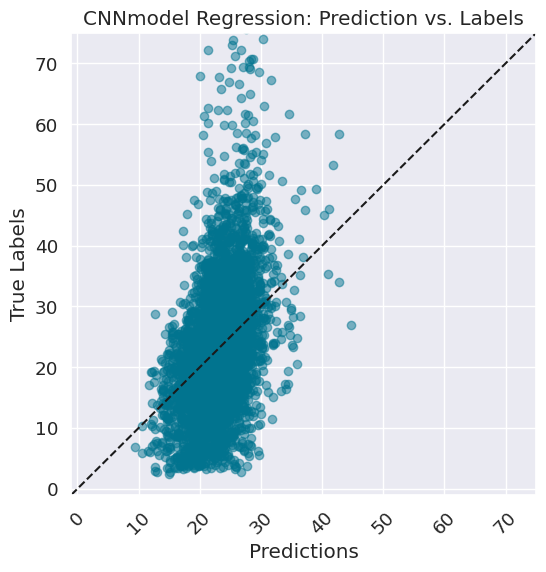

In [68]:
# # 输出两类图,
# # 一为 整体预测值 vs. 真实值的散点图,点为蓝色点。
# # 二为 单一特征 vs. 森林高度。黑色点为真实值，蓝色点为预测值。分别展示两个特定通道（第四通道和第五通道）特征与森林高度（真实值和预测值）的关系。
pred_vs_true(bmodel, "CNNmodel", X_test, y_test)

In [69]:
# 计算均方误差（MSE）、均方根误差（RMSE）、平均绝对误差（MAE）和平均绝对百分比误差（MAPE）。
# 这些指标用于评估模型在测试集上的性能。
from sklearn.metrics import mean_absolute_percentage_error as mape, r2_score

# 计算 MAPE
mape_cnn = mape(y_test, y_pred_cnn)
# 计算 R²
r2_cnn = r2_score(y_test, y_pred_cnn)
# 调整后R²
n_samples = X_test.shape[0]
n_features = X_test.shape[3]
adjusted_r2_cnn = 1 - (1 - r2_cnn) * (n_samples - 1) / (n_samples - n_features - 1) # X_test 形状为 (N, H, W, C)
# calculate metrics
mse_cnn = mse(y_test, y_pred_cnn)
rmse_cnn = mse_cnn ** (1/2)
mae_cnn = mae(y_test, y_pred_cnn)
mape_cnn = mape(y_test, y_pred_cnn)

# print(mape_cnn)
# print(mae_cnn)
# print(rmse_cnn)
# print(r2_cnn)
print('MAPE: {:0.2f}%'.format(mape_cnn))
print('MAE: {:0.4f}'.format(mae_cnn))
print('RMSE: {:0.4f}'.format(rmse_cnn))
print('R²: {:0.4f}'.format(r2_cnn))
print('Adjusted R²: {:0.4f}'.format(adjusted_r2_cnn))  # 新增行

MAPE: 0.43%
MAE: 7.3018
RMSE: 10.6304
R²: 0.1555
Adjusted R²: 0.1543


### 模型评价指标可视化

代码通过计算和比较模型在训练集和测试集上的误差和拟合优度指标（MSE、RMSE、MAE、R²），并使用柱状图可视化两者的表现，帮助评估模型的性能是否存在过拟合或欠拟合的情况，从这些指标可以看出，模型在训练集和测试集上的表现较为接近，说明模型没有严重的过拟合或欠拟合现象，虽然测试集上的误差略高于训练集，但差异并不大，表明模型具有较好的泛化能力

564/564 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


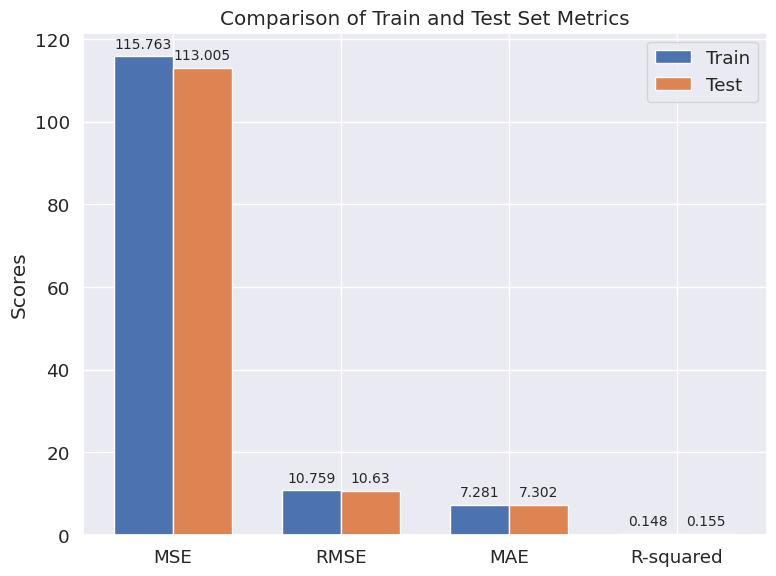

In [70]:
from sklearn import metrics
# 预测
y_pred_train = bmodel.predict(X_train)
y_pred_test = bmodel.predict(X_test)

y_pred_train_list = y_pred_train.tolist()
y_pred_test_list = y_pred_test.tolist()

# 计算训练集的指标
mse_train = metrics.mean_squared_error(y_train, y_pred_train_list)
rmse_train = np.sqrt(mse_train)
mae_train = metrics.mean_absolute_error(y_train, y_pred_train_list)
r2_train = metrics.r2_score(y_train, y_pred_train_list)

# 计算测试集的指标
mse_test = metrics.mean_squared_error(y_test, y_pred_test_list)
rmse_test = np.sqrt(mse_test)
mae_test = metrics.mean_absolute_error(y_test, y_pred_test_list)
r2_test = metrics.r2_score(y_test, y_pred_test_list)

# 将指标放入列表
metrics_labels = ['MSE', 'RMSE', 'MAE', 'R-squared']
train_metrics = [mse_train, rmse_train, mae_train, r2_train]
test_metrics = [mse_test, rmse_test, mae_test, r2_test]

# 创建柱状图
x = np.arange(len(metrics_labels))  # 横坐标位置
width = 0.35  # 柱子的宽度

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(8, 6))  # 设置图像尺寸

# 训练集和测试集的柱子
bars1 = ax.bar(x - width/2, train_metrics, width, label='Train')
bars2 = ax.bar(x + width/2, test_metrics, width, label='Test')

# 添加标签和标题
ax.set_ylabel('Scores')
ax.set_title('Comparison of Train and Test Set Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics_labels)
ax.legend()

# 在每个柱子上显示数值
def autolabel(bars):
    """在每个柱子上显示数值."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    # xytext=(0, 3),  # 3 点垂直偏移
                    xytext=(0, 4),  # 将文本稍微向上偏移
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)  # 设置字体大小

autolabel(bars1)
autolabel(bars2)

fig.tight_layout()
plt.savefig("Comparison of Train and Test Set Metrics.pdf", format='pdf',bbox_inches='tight')
plt.show()

### 模型预测可视化

代码通过散点图、回归线、直方图和拟合优度（R²）值的可视化方式，直观展示模型在训练集和测试集上的预测表现，对角线 x=y 表示理想状态下的预测，散点的偏离程度和回归线的拟合情况则表明了模型的实际预测能力，通过这些图表，可以很好地评估模型的准确性和泛化能力

<Figure size 9600x7200 with 0 Axes>

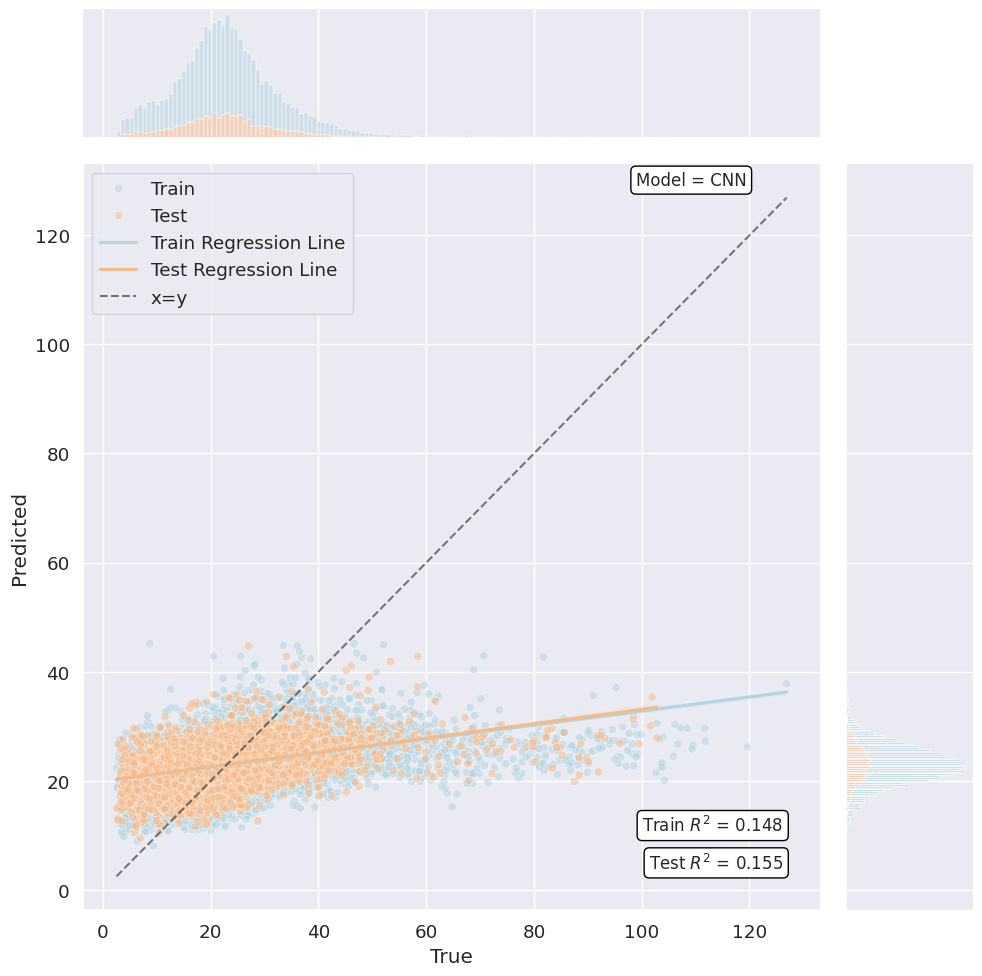

In [71]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

y_train = y_train.flatten()  # 确保y_train是一维
y_pred_train = y_pred_train.flatten()  # 确保y_pred_train是一维
y_test = y_test.flatten()  # 确保y_test是一维
y_pred_test = y_pred_test.flatten()  # 确保y_pred_test是一维

# 创建一个包含训练集和测试集真实值与预测值的数据框
data_train = pd.DataFrame({
    'True': y_train,
    'Predicted': y_pred_train,
    'Data Set': 'Train'
})

data_test = pd.DataFrame({
    'True': y_test,
    'Predicted': y_pred_test,
    'Data Set': 'Test'
})

data = pd.concat([data_train, data_test])

# 自定义调色板
palette = {'Train': '#b4d4e1', 'Test': '#f4ba8a'}

# 创建 JointGrid 对象
plt.figure(figsize=(8, 6), dpi=1200)
g = sns.JointGrid(data=data, x="True", y="Predicted", hue="Data Set", height=10, palette=palette)

# 绘制中心的散点图
g.plot_joint(sns.scatterplot, alpha=0.5)
# 添加训练集的回归线
sns.regplot(data=data_train, x="True", y="Predicted", scatter=False, ax=g.ax_joint, color='#b4d4e1', label='Train Regression Line')
# 添加测试集的回归线
sns.regplot(data=data_test, x="True", y="Predicted", scatter=False, ax=g.ax_joint, color='#f4ba8a', label='Test Regression Line')
# 添加边缘的柱状图
g.plot_marginals(sns.histplot, kde=False, element='bars', multiple='stack', alpha=0.5)

# 添加拟合优度文本在右下角
ax = g.ax_joint
ax.text(0.95, 0.1, f'Train $R^2$ = {r2_train:.3f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='bottom', horizontalalignment='right', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
ax.text(0.95, 0.05, f'Test $R^2$ = {r2_test:.3f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='bottom', horizontalalignment='right', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
# 在左上角添加模型名称文本
ax.text(0.75, 0.99, 'Model = CNN', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='left', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# 添加中心线
ax.plot([data['True'].min(), data['True'].max()], [data['True'].min(), data['True'].max()], c="black", alpha=0.5, linestyle='--', label='x=y')
ax.legend()
plt.savefig("TrueFalse.pdf", format='pdf', bbox_inches='tight')
plt.show()

### 环形图和条形图组合绘图

通过组合柱状图和同心饼图的方式，直观展示各个特征在模型中的贡献度，以及各个类别对模型的整体贡献。柱状图显示特征的详细贡献，饼图则提供了类别层面的总体贡献展示，使得用户能够从全局和细节两方面理解特征的重要性，**这里读者其实是不需要单独去绘制环形图和条形图的，**作者只是为了让读者更方便理解，其次这里的环形图和文献的环形图刚好是相反的，作者这里外圈是特征类别总贡献度，内圈是各个特征具体的贡献度映射，对于模型解读并没有区别

可视化解读：年龄（age）作为“基本信息”类别的特征贡献度最高，DFA作为“非线性”特征也具有显著贡献，外圈饼图显示“基本信息”类别占总贡献的 71.5%，而“非线性”特征占 20%，其余类别如“噪声”、“抖动”和“振幅”特征的贡献较小，内圈的特征贡献进一步细分了各类别中具体特征的贡献度，帮助直观理解特征对模型预测的重要性。需要注意的是，这个结果基于演示用的复现数据，对于实际生活中的情况并不一定具有直接的参考价值

In [ ]:
# shap原始特征贡献可视化

import shap
# 构建 shap解释器
# shap.DeepExplainer 专门用于深度学习模型，如神经网络。它基于 SHAP 和 DeepLIFT 算法，能够有效地计算深度学习模型的 SHAP 值。 DeepExplainer 会自动处理模型的内部结构，计算每个特征对预测结果的影响。
# 在使用 DeepExplainer 时，通常只需要提供两个参数，分别是：模型对象和训练数据集。其中，model 是训练好的深度学习模型，X_train 是训练数据集。
explainer = shap.DeepExplainer(bmodel, X_train)

# 计算测试集的shap值
# 对于回归问题，shap_values是一个形状为(num_samples, num_features)的数组。
# 检查shap_values的维度，并确保shap_values是一个二维数组，包含了每个样本和每个特征的贡献值。
shap_values = explainer.shap_values(X_test)

# # 特征标签
# 假设有6个特征
labels_columns = ['Height', 'Mean_HH_DirMean', 'Mean_HV_DirMean', 'RLD_20', 'sigmadB_HV', 'SinAspect']

# # 绘制SHAP值总结图（Summary Plot）
# plt.figure(figsize=(15, 5))
# shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
# plt.title("SHAP_Feature_Importance_Raw_Output")
# plt.savefig("SHAP_Feature_Importance_Raw_Output.pdf", format='pdf',bbox_inches='tight')
# plt.show()


# 打印 SHAP 值的形状，检查它的维度
print(shap_values.shape)  # 输出形状 (11722, 6, 1)
# 这种情况下就转变为了"如何正确计算每个特征的平均 SHAP 值"

# 如果 SHAP 值是三维数组，选择第一维来计算贡献度
# 对每个特征的贡献度求绝对值的平均
# feature_contributions = np.abs(shap_values).mean(axis=0)
# 计算每个特征的平均贡献度，取绝对值并在样本维度（axis=0）求平均
feature_contributions = np.abs(shap_values).mean(axis=0).flatten()

# 确保feature_contributions是一个一维数组，这样在创建DataFrame时，数据的维度是匹配的。
# 创建一个DataFrame，其中一列是特征名，另一列是特征贡献度
contribution_df = pd.DataFrame({
    'Feature': labels_columns,
    'Contribution': feature_contributions
})

# 创建类别规则
Category = ['Terrain', 'texture', 'Backscattering']

# 特征对应的类别
category_map = {
    'Height': 'Terrain',
    'Mean_HH_DirMean': 'texture',
    'Mean_HV_DirMean': 'texture',
    'RLD_20': 'Terrain',
    'sigmadB_HV': 'Backscattering',
    'SinAspect': 'Terrain'
}

# 将类别映射到DataFrame
contribution_df['Category'] = contribution_df['Feature'].map(category_map)

# 打印 DataFrame
print(contribution_df)
# contribution_df


/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:155: UserWarning: You have provided over 5k background samples! For better performance consider using smaller random sample.
  warnings.warn("You have provided over 5k background samples! For better performance consider using smaller random sample.")
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_1
Received: inputs=['Tensor(shape=(18036, 5, 5, 6))'

In [ ]:

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 环形图和条形图组合绘图
# 按类别和贡献度对数据进行排序，确保同一类别的特征在一起，贡献度从高到低排列
contribution_df_sorted = contribution_df.sort_values(by=['Category', 'Contribution'], ascending=[True, False])

# 创建一个用于生成颜色渐变的函数
def get_color_gradient(base_color, num_shades):
    # 生成从浅到深的颜色渐变
    gradient = np.linspace(0.4, 1, num_shades)  # 生成从较浅（0.4）到原色（1）的渐变
    return [(base_color[0], base_color[1], base_color[2], shade) for shade in gradient]

# 为三个类别定义颜色
category_colors = {
    'Terrain': (0.9, 0.7, 0.2, 1),  # 黄色
    # 'texture': (0.6, 0.3, 0.9, 1),     # 紫色
    'texture': (0.7, 0.3, 0.3, 1),      # 暗红
    # 'Non-linear': (0.2, 0.9, 0.9, 1), # 青色
    'Backscattering': (0.3, 0.6, 0.9, 1),    # 浅蓝
}

# 默认颜色，如果类别未定义时使用
default_color = (0.8, 0.8, 0.8, 1)  # 灰色

# 获取内圈和外圈的贡献度数据
inner_contribution = contribution_df_sorted.groupby('Category')['Contribution'].sum()
outer_contribution = contribution_df_sorted.set_index('Feature')['Contribution']

# 检查是否有未定义的类别
undefined_categories = set(inner_contribution.index) - set(category_colors.keys())
if undefined_categories:
    print(f"Warning: 以下类别没有定义颜色，将使用默认颜色: {undefined_categories}")

# 为每个类别在外圈创建颜色渐变
outer_colors = []
for category in inner_contribution.index:
    # 选取当前类别的数据
    category_df = contribution_df_sorted[contribution_df_sorted['Category'] == category]
    # 获取类别的基础颜色，如果没有定义则使用默认颜色
    base_color = category_colors.get(category, default_color)
    # 为当前类别生成颜色渐变
    gradient_colors = get_color_gradient(base_color, len(category_df))
    outer_colors.extend(gradient_colors)

# 内外圈的标签准备
inner_labels = inner_contribution.index
outer_labels = outer_contribution.index

# 创建图形和子图
# fig, ax = plt.subplots(figsize=(10, 8), dpi=1200)
fig, ax = plt.subplots(figsize=(12, 10), dpi=1200)

# 设置背景颜色为淡灰色
ax.set_facecolor('#f0f0f0')

# 添加网格线，设置网格线样式
ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)


# ---- 绘制柱状图 ----
# 按贡献度从高到低排序
contribution_df_sorted = contribution_df.sort_values(by='Contribution', ascending=False)

# 准备颜色列表
bar_colors = [category_colors.get(cat, (0.8, 0.8, 0.8, 1)) for cat in contribution_df_sorted['Category']]


# 绘制条形图
# 调整条形图的宽度，height=0.3 可以让条形图更窄
ax.barh(contribution_df_sorted['Feature'], contribution_df_sorted['Contribution'], color=bar_colors, height=0.6)

# 添加图例
handles = [plt.Rectangle((0, 0), 1, 1, color=category_colors[cat]) for cat in category_colors]
labels_columns = list(category_colors.keys())
ax.legend(handles, labels_columns, loc='lower right')

# 设置标签和标题
ax.set_xlabel('Contribution')
ax.set_ylabel('Feature')
ax.set_title('Feature Contributions by Category')

# 反转y轴，以便贡献度最大的特征在顶部
ax.invert_yaxis()


# ---- 在柱状图中嵌入同心饼图 ----

# 为环形图创建嵌入坐标轴
# width=2, height=2: 这定义了插图的宽度和高度为 2（单位是 inch，英寸）。因此，插图较小。
# bbox_to_anchor 控制插图的位置和大小。
# 0.8 和 0.35 指定插图的 左下角 在主图坐标系中的位置（相对于 ax 的坐标轴），表示插图将从主图的右侧偏移 80% 和从上面偏移 35%。
# 0.2 和 0.2 是插图的宽度和高度比例，表示插图的大小是主图宽度和高度的 20%。
inset_ax = inset_axes(ax, width=3, height=3, loc='upper right', bbox_to_anchor=(0.8, 0.35, 0.2, 0.2), bbox_transform=ax.transAxes)

# 绘制内圈饼图（类别级别的饼图），显示百分比，不显示标签
inset_ax.pie(inner_contribution, labels_columns=['']*len(inner_contribution), autopct='%1.1f%%', radius=1,
       colors=[category_colors.get(cat, default_color) for cat in inner_labels],
       wedgeprops=dict(width=0.3, edgecolor='w'),
       pctdistance=0.85)  # 增加pctdistance来防止数字重叠

# 绘制外圈饼图（特征级别的饼图），显示百分比，不显示标签
inset_ax.pie(outer_contribution, labels_columns=['']*len(outer_contribution), autopct='%1.1f%%', radius=0.7,
       colors=outer_colors,
       wedgeprops=dict(width=0.3, edgecolor='w'),
       pctdistance=0.75)  # 增加pctdistance来防止数字重叠


# 添加白色中心圆，形成环形图
inset_ax.add_artist(plt.Circle((0, 0), 0.4, color='white'))

plt.savefig("CNN_Combined_Feature_Contributions_and_Circular_Chart.pdf", format='pdf',bbox_inches='tight')

# 显示图表
plt.show()



In [ ]:
# 启动 TensorBoard 可视化工具，查看训练过程中的详细信息，如损失曲线、准确率曲线、权重分布等。
%tensorboard --logdir logs

In [ ]:
# ypred_cnn[:] 和 labels[:] 都是对数组的切片操作，表示返回数组中的所有元素，分别是预测值和真实标签值。
# 无论数组的维度是多少，使用 [:] 都是返回数组中的所有元素。这是 NumPy 中的一个常见用法，它用于获取数组的完整内容，不论数组是多维的。(保持其原有的形状。)

# 计算预测结果的均值
# ypred_cnn 的形状应为 (n, 1)，即一个列向量，每一行代表一个样本的预测结果。如果你打印 ypred_cnn[:]，你将得到模型对所有测试样本的预测结果。
mean_cnn = np.mean(y_pred_cnn[:]) #calculate mean
# 计算预测结果的分位数
quantiles_cnn = np.percentile(y_pred_cnn[:], [1, 25, 50, 75, 99]) #calculate quantiles 0.01, 0.25, 0.5, 0.75, 0.99

# 计算标签的均值
# labels 是一个形状为 (n,) 的一维数组，存储了对应测试样本的实际标签（真实的森林高度）。
# labels[:] 会返回所有的标签值。
mean_labels = np.mean(labels[:])
# 计算标签的分位数
quantiles_labels = np.percentile(labels[:], [1, 25, 50, 75, 99])

print(mean_cnn)
print(quantiles_cnn)
# 打印预测值中最小的 10 个和最大的 10 个。
print(np.sort(y_pred_cnn.flatten())[:10]) #print the 10 lowest predictions
print(np.sort(y_pred_cnn.flatten())[-10:][::-1]) #print the 10 highest predictions

print(mean_labels)
print(quantiles_labels)
# 打印标签中最小的 10 个和最大的 10 个。
print(np.sort(labels.flatten())[:10])
print(np.sort(labels.flatten())[-10:][::-1])

# Prediction of test image convolutional neural network

这里使用的直接是前面NN模型中为了对测试图像进行预测从而对测试图像进行分割所得的测试图像块，测试图像的大小为1024*1024，通道数为11，即形状为（11，1024，1024）。

所以下面的代码中 X 的形状才为（11，1024，1024）。

### 加载训练好的模型并预测

In [ ]:
# # 加载测试数据并切分为图像块（patches）

# # 设置存储图像块的文件夹路径
# folder_path = '/content/drive/My Drive/data/images/'  # 文件夹路径，存放测试图像块
# # 加载训练好的模型
# cnnmodel = load_model('/content/drive/My Drive/forest_height/models/CNNmodels/best_CNNmodel_Std.keras')  # 加载已经训练好的CNN模型
# # 初始化索引变量，用于保存预测结果
# ind = 0

# # Iterate over the files in the folder
# for filename in os.listdir(folder_path):
#     file_path = os.path.join(folder_path, filename)
#     if os.path.isfile(file_path):
#       X = np.load(file_path)

#       #  不需要额外进行标准化这一步，因为在CNN模型中内置了标准化层

#       # 零填充
#       # 因为卷积神经网络通常需要固定大小的输入，为了符合网络输入要求，这里对图像块 X 零填充
#       # 这里的 pad_width 是一个 元组，它描述了三个维度的填充方式。即在通道维度上不进行填充，图像的通道数不改变，维度保持不变。在第二和第三个轴上(即 高度维度 和 宽度维度)进行宽度为 2 的填充, 填充的大小为 (2, 2)，意味着在每个图像高度的上方和下方和宽度的左侧和右侧各添加 2 行/列的零。因此，图像的高度会增加 4 个像素, 图像的宽度会增加 4 个像素。这样做的目的是为了保证卷积操作的窗口大小不变。
#       # Pad width of 2 on the second and third axes to (6, 1028, 1028) to get output of shape (6, 1024, 1024) with a window of size 5
#       pad_width = ((0, 0), (2, 2), (2, 2))  # Pad width of 2 on the second and third axes to (6, 1028, 1028) to get output of shape (9, 1024, 1024) with a window of size 5
#       # mode='constant' 表示使用常数值填充。constant_values=0 指定填充的常数值为 0。
#       # 经过填充后的图像形状将变为 (6, 1028, 1028)。
#       X = np.pad(X, pad_width, mode='constant', constant_values=0)

#       # 获取图像的高度和宽度, 也就可以看出这个 X 的形状为(channels, height, width)
#       height, width = X.shape[1], X.shape[2] #get height an width of the image

#       from skimage.util import view_as_windows
#       # 下面这段通过双重循环切割窗口的方法可以使用更简洁的滑动窗口生成方法，利用skimage.util.view_as_windows 生成滑动窗口。
#       # 使用滑动窗口生成图像块（更高效的方式）
#       # 输入形状为 (channels, height, width) = (6, 1028, 1028)
#       datat = view_as_windows(X, (6, 5, 5), step=1)
#       datat = datat.reshape(-1, 5, 5, 6)  # 转换为 NHWC 格式
#       # 预测
#       pred = cnnmodel.predict(datat)

#       # 重塑为原始图像大小 (1024, 1024)
#       img = pred.reshape(1024, 1024)

#       # 保存预测结果
#       np.save(f'/content/drive/My Drive/forest_height/MaskCNN/mask_{ind}.npy', img)
#       ind += 1

#       # 打印预测图像的形状
#       print(f"预测图像形状: {img.shape}")

In [ ]:
# # 加载测试数据并切分为图像块（patches）

# # 设置存储图像块的文件夹路径
# folder_path = '/content/drive/My Drive/data/images/'  # 文件夹路径，存放测试图像块
# # 加载训练好的模型
# cnnmodel = load_model('/content/drive/My Drive/forest_height/models/CNNmodels/best_CNNmodel_Std.keras')  # 加载已经训练好的CNN模型
# # 初始化索引变量，用于保存预测结果
# ind = 0

# # Iterate over the files in the folder
# for filename in os.listdir(folder_path):
#     file_path = os.path.join(folder_path, filename)
#     if os.path.isfile(file_path):
#       X = np.load(file_path)

#       #  不需要额外进行标准化这一步，因为在CNN模型中内置了标准化层

#       # 零填充
#       # 因为卷积神经网络通常需要固定大小的输入，为了符合网络输入要求，这里对图像块 X 零填充
#       # 这里的 pad_width 是一个 元组，它描述了三个维度的填充方式。即在通道维度上不进行填充，图像的通道数不改变，维度保持不变。在第二和第三个轴上(即 高度维度 和 宽度维度)进行宽度为 2 的填充, 填充的大小为 (2, 2)，意味着在每个图像高度的上方和下方和宽度的左侧和右侧各添加 2 行/列的零。因此，图像的高度会增加 4 个像素, 图像的宽度会增加 4 个像素。这样做的目的是为了保证卷积操作的窗口大小不变。
#       # Pad width of 2 on the second and third axes to (6, 1028, 1028) to get output of shape (6, 1024, 1024) with a window of size 5
#       pad_width = ((0, 0), (2, 2), (2, 2))  # Pad width of 2 on the second and third axes to (6, 1028, 1028) to get output of shape (6, 1024, 1024) with a window of size 5
#       # mode='constant' 表示使用常数值填充。constant_values=0 指定填充的常数值为 0。
#       # 经过填充后的图像形状将变为 (6, 1028, 1028)。
#       X = np.pad(X, pad_width, mode='constant', constant_values=0)

#       # 获取图像的高度和宽度, 也就可以看出这个 X 的形状为(channels, height, width)
#       height, width = X.shape[1], X.shape[2] #get height an width of the image

#       # 提取图像块的窗口
#       # 定义窗口大小为 5x5
#       window_size = 5
#       # 定义窗口形状，6个通道（假设输入是6个通道），5x5窗口
#       shape = (6, window_size, window_size)
#       # 创建一个形状为 (6, 5, 5) 的数组，填充为1
#       datat = np.ones(shape) #array for features
#       # 扩展维度，使其成为 (1, 6, 5, 5)
#       datat = np.expand_dims(datat, axis=0)

#       # 对图像进行切割，提取滑动窗口

#       # 选择第一行（6, 5, 5）的窗口（这里的第一行指的是将所有的图像块提取出来拼接后，这部分代码提取出来的就是该拼接图像的第一行图像）
#       for w in range(width - window_size + 1): # select the first row (6, 5, 5) patches
#         # 从图像中提取一个5x5的窗口
#         # w 就是滑动窗口的左端点（注意是左端点，所以没问题），每次 w 增加 1，表示窗口向右滑动 1 个像素。
#         sample = X[:, 0:window_size, w:w+window_size]
#         sample2 = np.expand_dims(sample, axis=0)
#         datat = np.concatenate((datat, sample2), axis=0)

#       datat = datat[1:,:,:,:] #remove the first artificial patch

#       # 遍历每一行
#       # 对图像的每一行进行处理，提取窗口（注意：这里的每一行指的就不是刚才那个拼接窗口的图像了，而是指输入进行窗口切割的图像）
#       # 这里height - window_size而不是height - window_size + 1 是因为上一段代码已经提取出来了第一行（6, 5, 5）的窗口，所以循环次数少1
#       for h in range(height - window_size): # iterate over the rows
#         # 创建一个形状为 (6, 1, 5) 的空数组
#         shape = (6, 1, window_size)
#         datat2 = np.ones(shape) #array for the values of one row
#         # 扩展维度，使其成为 (1, 6, 1, 5)
#         datat2 = np.expand_dims(datat2, axis=0)
#         # 遍历每一列
#         for w in range(width - window_size  + 1): # iterate over the columns
#           # 提取窗口
#           # sample 的形状是 (6, window_size)
#           # 由于你只选择了一个高度索引（h+window_size），所以返回的是一个 (6, window_size) 的数组。6 是通道数，window_size 是窗口大小（即列数）
#           # Python 和 NumPy 通常会“自动去掉”维度为 1 的通道（即，当某个维度的大小为 1 时，这个维度可能被省略）。
#           sample = X[:, h+window_size, w:w+window_size]
#           # 扩展维度，变为 (6, 1, window_size)
#           sample = np.expand_dims(sample, axis=1)
#           # 扩展维度，变为 (1, 6, 1, window_size)
#           # 第一维度 1 代表了“批量大小”（batch size），意味着这个样本是一个单独的样本，且是批处理的一部分。
#           # 第三维度 1 代表了窗口的高度（即对单行窗口的处理）。
#           sample = np.expand_dims(sample, axis=0)
#           # 将窗口添加到 datat2 数组中
#           datat2 = np.concatenate((datat2, sample), axis=0) #collect values from one row

#         # 拼接前一行的处理结果（即 datat）和当前行的窗口数据（即 datat2）。
#         # 这个操作与处理行 h 相关，确保从前一行的结果中正确地选择出窗口数据。这里的 h 是当前行的索引。
#         # 这部分代码确实没错，因为 datat 是最终存储拼接图像块的数组（注意这个拼接图像块是一行一行拼接的，不是一个一个拼接的），而这里构建每一行的图像块是采取的保留前一行图像块的后 size -1 行高度，然后再拼接新的当前高度的图像块。
#         # 而保留前一行图像块，则需要将前面剩余行的图像块删去即使用 datat的(width-window_size+1)*h: 来实现。而保留前一块图像块中的后 size - 1 行高度，则使用 datat 的1: 来实现。
#         datat4 = np.concatenate((datat[(width-window_size+1)*h:,:,1:,:], datat2[1:,:,:,:]), axis=2) #remove the first column from the previous row patches and add a new row below
#         datat = np.concatenate((datat, datat4), axis=0) #stack the patches


#       # 我前面定义的 CNN 模型输入形状为 (5, 5, 6)（NHWC 格式），但测试代码中的图像块 datat 形状为 (n, 6, 5, 5)（NCHW 格式）。需转换为 NHWC 格式。
#       # 将通道维度移到最后一维，转换为 (n, 5, 5, 6)
#       datat = datat.transpose(0, 2, 3, 1)

#       # 使用CNN模型进行预测
#       # 如果您传入的 datat 形状是 (n, 6, 5, 5)，则经过卷积层和池化层后，最终输出的形状为 (n, 1)，其中 n 是样本的数量（即输入数据的批大小）。
#       # 返回的预测结果是一个形状为 (num_samples, 1) 的数组，其中每一行是一个预测的标量值。
#       pred = cnnmodel.predict(datat) #predict labels
#       # 重塑预测结果为原始图像大小
#       img = pred.transpose().reshape(1,1024,1024) #reshape image to original size

#       # 保存预测结果
#       np.save('/content/drive/My Drive/forest_height/MaskCNN/mask_'+ str(ind) + '.npy', img)
#       # 更新索引
#       ind = ind + 1
#       # 打印预测图像的形状
#       print(img.shape) #metrics to control the prediction process for every patch image
#       # 输出预测值的分位数
#       print(np.percentile(pred[:], [1, 25, 50, 75, 99]))
#        # 输出最小的10个预测值
#       print(np.sort(pred.flatten())[:10])
#       # 输出最大的10个预测值
#       print(np.sort(pred.flatten())[-10:][::-1])



### 重建预测图像并保存

In [ ]:
# folder_path = '/content/drive/My Drive/forest_height/MaskCNN/'  #folder path
# img_list = []

# # Iterate over the files in the folder
# for filename in os.listdir(folder_path):
#     file_path = os.path.join(folder_path, filename)
#     if os.path.isfile(file_path):
#         # Load the data from the file
#         data = np.load(file_path)
#         # Append the data to the list
#         img_list.append(data)  #将预测结果添加到列表中

# # 我有 143 个切片（按 13 x 11 进行排列），可以利用这些切片的索引按列和按行拼接来恢复完整的图像。
# # 假设img_list包含所有的切片，已经按正确顺序加载
# m = 11  # 高度方向的切片数量
# n = 13  # 宽度方向的切片数量

# # 将每13个图像块按列(宽度方向)拼接
# # Concatenate the patches along the columns (horizontal axis)
# # 按列拼接每行的切片
# rows = []
# for i in range(m):
#     row = np.concatenate(img_list[i*n:(i+1)*n], axis=2)  # 按列拼接
#     rows.append(row)

# # 按行拼接
# original_image = np.concatenate(rows, axis=1)  # 按行拼接

# # # Concatenate the patches along the columns (horizontal axis)
# # im1 = np.concatenate((img_list[0], img_list[1], img_list[2], img_list[3]), axis=2)
# # im2 = np.concatenate((img_list[4], img_list[5], img_list[6], img_list[7]), axis=2)
# # im3= np.concatenate((img_list[8], img_list[9], img_list[10], img_list[11]), axis=2)
# # im4 = np.concatenate((img_list[12], img_list[13], img_list[14], img_list[15]), axis=2)

# # # Concatenate the rows along the vertical axis to rebuild the original image
# # original_image = np.concatenate((im1, im2, im3, im4), axis=1)

# np.save('/content/drive/My Drive/forest_height/MaskCNN/FinalPredictions/mask_private_cnn.npy', original_image)


### 可视化预测结果

In [ ]:
# plot_rebuild_image = np.load('/content/drive/My Drive/forest_height/MaskCNN/FinalPredictions/mask_private_cnn.npy')
# # 将重建的预测图像由 (1, height, width) 转换为 (height, width)
# tree_height_2d = plot_rebuild_image[0]

# # Plot the tree height data
# plt.imshow(tree_height_2d, cmap='viridis')

# # Add colorbar for reference
# plt.colorbar() # 添加颜色条

# # Display the plot
# plt.show()

### 输出预测结果的分位数和极值

In [ ]:
# print(np.percentile(plot_rebuild_image[:], [1, 25, 50, 75, 99])) #calculate quantiles 0.01, 0.25, 0.5, 0.75, 0.99

# print(np.sort(plot_rebuild_image.flatten())[:10]) #print the 10 lowest predictions
# print(np.sort(plot_rebuild_image.flatten())[-10:][::-1]) #print the 10 highest predictions

In [ ]:

# 保存带有输出的 notebook 文件到 Google Drive
!jupyter nbconvert --to pdf "/content/drive/My Drive/Colab Notebooks/NNandCNN_FeatureNormalization.ipynb"
